Loaded 1700 SNe from Pantheon+SH0ES.dat (using zHD, mu-like=MU_SH0ES)

=== MODEL COMPARISON ===
LCDM:        χ²=745.3, dof=1698, χ²_red=0.439, AIC=749.3, BIC=760.2
Rough(accum): χ²=740.2, dof=1697, χ²_red=0.436, AIC=746.2, BIC=762.5
Template(1p): χ²=744.9, dof=1697, χ²_red=0.439, AIC=750.9, BIC=767.2
Δχ² (LCDM→Rough)    = 5.08 for -1 params
Δχ² (LCDM→Template) = 0.35 for -1 params
A (template) = -0.07999 ± 0.02343  [sqrtz_J ; Ωm_ref=1.0]

Saved figures: dmu_vs_chi.png, dmu_vs_zeta.png, template_* .png, overlay_*.png
Saved table  : bin_summary_zHD.csv


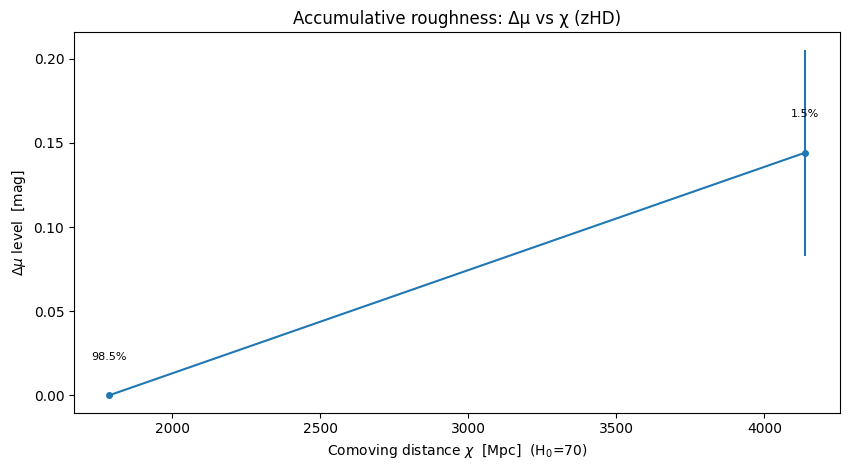

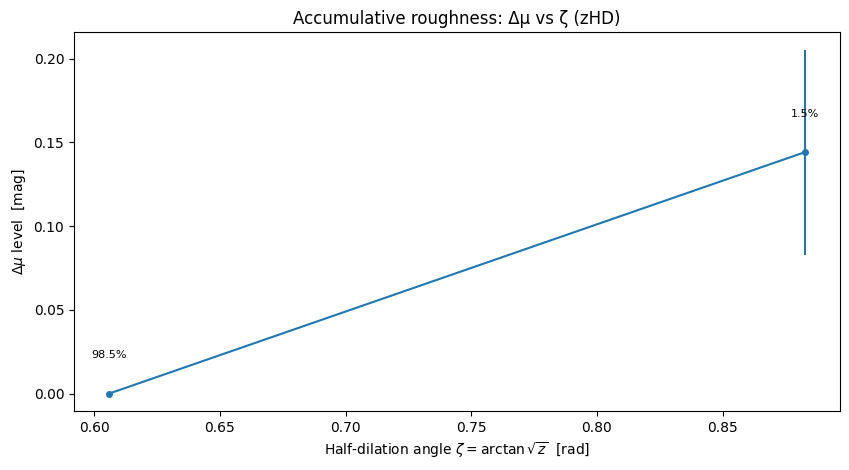

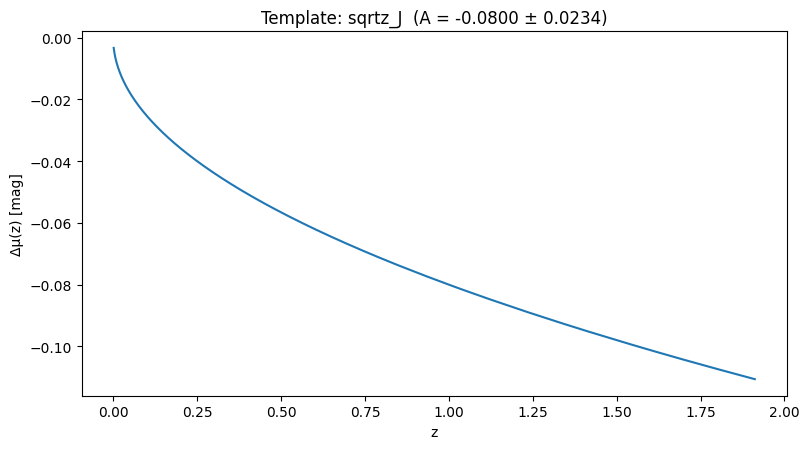

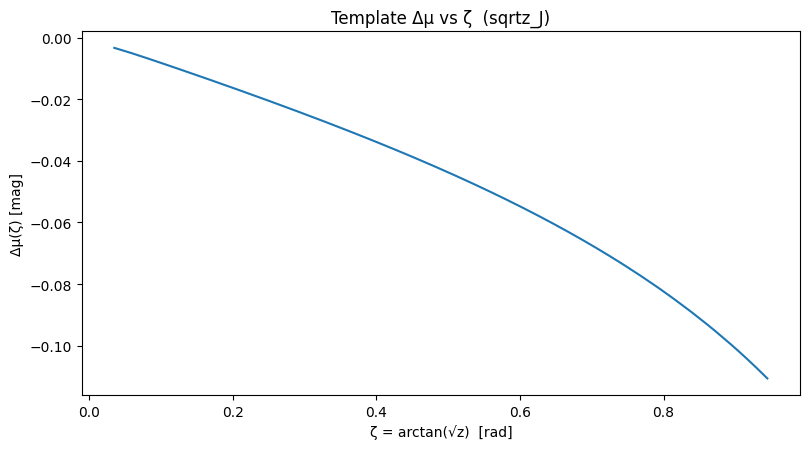

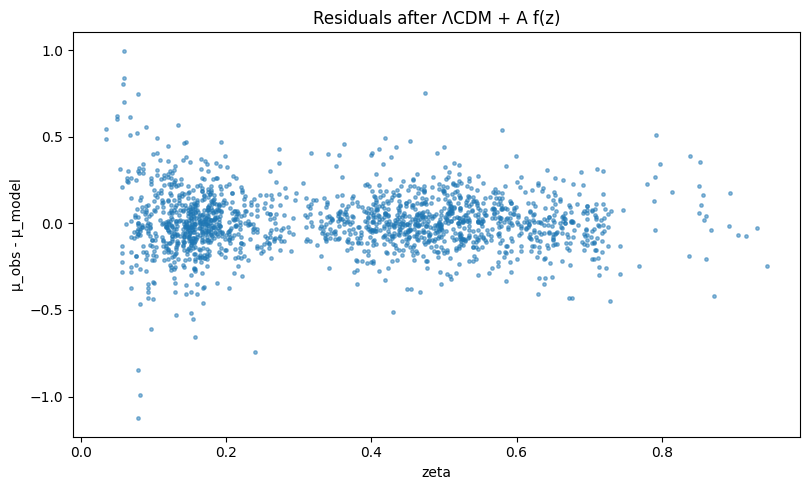

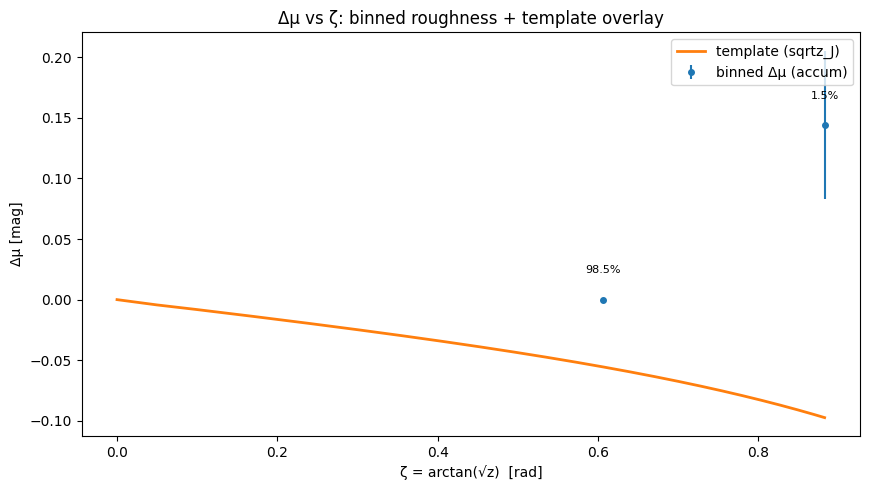

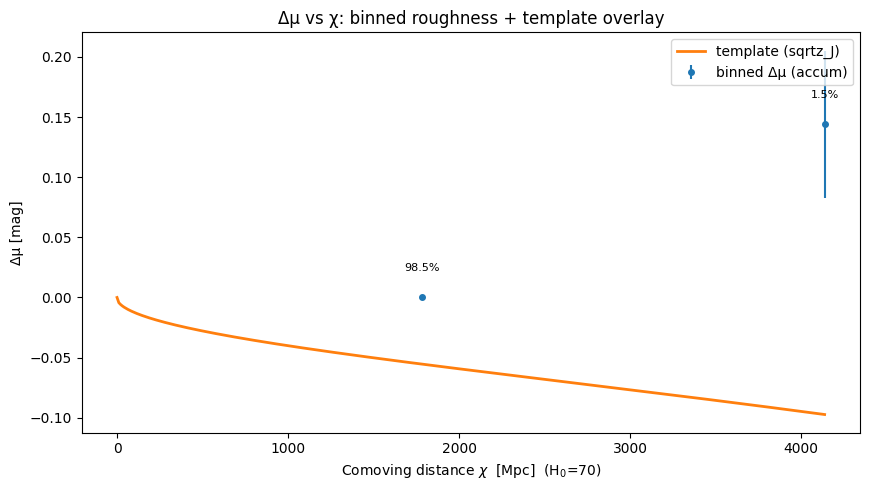

In [16]:
# pantheon_zHD_accum_check_v2.py
"""
Pantheon+ zHD — Accumulative Roughness Checker (v2)

Adds:
- 1-parameter *accumulative* template fit (choose TEMPLATE_KIND):
    * "sqrtz_J"   : f(z) = J(z; Ωm_ref) * sqrt(z)      [HD 'instant-turn' phenomenology]
    * "zeta_linear": f(z) = ζ(z) = arctan(sqrt(z))     [uniform in HD-angle]
    * "sec_linear" : f(z) = sqrt(1+z) - 1              [uniform in sec ζ]
    * "chi_linear" : f(z) ∝ χ(z; Ωm_ref) / max χ       [uniform in comoving distance]
- Model comparison: ΛCDM vs Rough(accum) vs Template(1p) with χ², dof, χ²_red, AIC, BIC.
- Overlay plots: template Δμ curve over binned roughness levels vs χ and vs ζ.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings

# ======= CONFIG =======
DATA_PATH = Path("./Pantheon+SH0ES.dat")
Z_BINS = np.array([0.0,0.96,2.0])
LAMBDA_SMOOTH = 1.0
SIGMA_FLOOR = 0.12
NINT = 10
H0 = 70.0
RIDGE = 1e-8

# Template settings
TEMPLATE_KIND  = "sqrtz_J"  # "sqrtz_J" | "zeta_linear" | "sec_linear" | "chi_linear"
TEMPLATE_OMREF = 1.0       # Ωm used in f(z) for "sqrtz_J" & "chi_linear"
# ======================

c_km_s = 299792.458
warnings.simplefilter("ignore", category=DeprecationWarning)

# --- HD angle & helpers ---
def z_to_zeta(z):
    z = np.asarray(z, float)
    return np.arctan(np.sqrt(np.clip(z, 0, None)))

# --- Loader (require zHD) ---
def _read_any(path: Path) -> pd.DataFrame:
    try:
        df = pd.read_table(path, comment='#', sep=r"\s+", engine="python")
        if len(df.columns) == 1:
            df = pd.read_csv(path, comment='#')
        return df
    except Exception:
        try:
            return pd.read_csv(path, comment='#')
        except Exception:
            return pd.read_csv(path, delim_whitespace=True, comment='#')

def load_sn_table(path: Path):
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")
    df = _read_any(path)
    if len(df.columns) == 1:
        df = pd.read_table(path, comment='#', sep=r"\s+", engine="python")

    cols_lower = {c.lower().strip(): c for c in df.columns}
    def pick_exact(name): return cols_lower.get(name.lower())

    zcol = pick_exact('zhd')
    if zcol is None: raise ValueError("This checker requires zHD column. Not found.")
    mucol  = (cols_lower.get('mu') or cols_lower.get('mu_sh0es') or
              cols_lower.get('distmod') or cols_lower.get('m_b_corr') or
              cols_lower.get('mb_corr') or cols_lower.get('mb'))
    sigcol = (cols_lower.get('mu_err') or cols_lower.get('sigma_mu') or
              cols_lower.get('mu_sh0es_err_diag') or cols_lower.get('m_b_corr_err_diag') or
              cols_lower.get('dmu') or cols_lower.get('dmb') or cols_lower.get('merr'))
    if mucol is None: raise ValueError("No mu-like column found.")

    out = pd.DataFrame()
    out['z'] = df[zcol].astype(float)
    out['mu_like'] = df[mucol].astype(float)
    out['sigma_mu'] = (df[sigcol].astype(float) if sigcol else SIGMA_FLOOR)
    out['sigma_mu'] = np.clip(out['sigma_mu'].values, SIGMA_FLOOR, None)
    out = out.replace([np.inf,-np.inf], np.nan).dropna(subset=['z','mu_like','sigma_mu'])
    out = out[(out['z']>=0.0) & (out['z']<=2.0)].sort_values('z').reset_index(drop=True)

    print(f"Loaded {len(out)} SNe from {path.name} (using zHD, mu-like={mucol})")
    return out

# --- Cosmology ---
def E_z(z, Om): return np.sqrt(Om*(1+z)**3 + (1-Om))

def comoving_distance(z, Om, H0=H0):
    z = float(z)
    if z <= 0: return 0.0
    zg = np.linspace(0.0, z, NINT)
    Ez = E_z(zg, Om)
    return (c_km_s/H0) * np.trapezoid(1.0/Ez, zg)

def lum_distance(z, Om, H0=H0):
    return (1+z)*comoving_distance(z, Om, H0)

def mu_theory(z, Om, M):
    Dl = np.array([lum_distance(zi, Om) for zi in np.atleast_1d(z)])
    return 5.0*np.log10(np.clip(Dl,1e-9,None)) + M

# Sensitivity J(z; Om): ∂ ln D_L / ∂ ln(1+z)
def J_sensitivity(z, Om):
    z = np.asarray(z, float)
    Ez = E_z(z, Om)
    chi = np.array([comoving_distance(zi, Om, H0=H0) for zi in z])
    with np.errstate(divide='ignore', invalid='ignore'):
        J = 1.0 + (1.0 + z) / (Ez * np.where(chi>0, chi, np.inf))
    J[~np.isfinite(J)] = 1.0  # guard near z=0
    return J

# --- Baseline ΛCDM ---
def fit_lcdm(sn_df, Om_grid=np.linspace(0.05,0.6,200)):
    z = sn_df['z'].values; y=sn_df['mu_like'].values; w=1.0/(sn_df['sigma_mu'].values**2)
    best=None
    for Om in Om_grid:
        mu0 = 5.0*np.log10(np.array([lum_distance(zi,Om) for zi in z]))
        M = np.sum(w*(y-mu0))/np.sum(w)
        r = y - (mu0 + M)
        chi2 = np.sum(w*r*r)
        if best is None or chi2<best['chi2']:
            best={'Om':float(Om),'M':float(M),'chi2':float(chi2)}
    N=len(y); k=2
    best['dof']=int(N-k); best['chi2_red']=best['chi2']/max(1,best['dof'])
    best['AIC']=best['chi2']+2*k; best['BIC']=best['chi2']+k*np.log(N)
    return best

# --- Design matrices ---
def design_matrix_bins(z, edges):
    B = np.zeros((len(z), len(edges)-1))
    for j in range(len(edges)-1):
        m = (z>=edges[j]) & (z<edges[j+1]); B[m,j]=1.0
    B[z>=edges[-1]-1e-10, -1]=1.0
    return B

def build_cumulative_steps(z, edges):
    z = np.asarray(z, float)
    Klev = len(edges)-1
    inner = edges[1:]
    zmax = np.max(z) if z.size>0 else -np.inf
    mask = inner <= (zmax + 1e-12)
    step_edges = inner[mask]
    Kc = len(step_edges)
    C = np.zeros((len(z), Kc))
    for m, thr in enumerate(step_edges):
        C[:, m] = (z >= thr).astype(float)
    T = np.zeros((Klev, Kc))
    for j in range(Klev):
        T[j, :min(j, Kc)] = 1.0
    return C, step_edges, T

# --- Accumulative roughness fit (robust) ---
def fit_lcdm_with_roughness_accum(sn_df, edges, lam=1.0, Om_grid=np.linspace(0.05,0.6,160)):
    z=sn_df['z'].values; y=sn_df['mu_like'].values; w=1.0/(sn_df['sigma_mu'].values**2)
    Klev = len(edges)-1
    C, step_edges, T = build_cumulative_steps(z, edges)
    Kc = C.shape[1]

    if Kc == 0:
        base = fit_lcdm(sn_df, Om_grid)
        base.update({'bin_edges':edges,'levels':np.zeros(Klev),'levels_err':np.zeros(Klev)})
        return base

    if Klev >= 3:
        D2 = np.zeros((Klev-2, Klev))
        for i in range(Klev-2): D2[i, i:i+3] = [1,-2,1]
        RtR_eps = T.T @ (D2.T @ D2) @ T
    else:
        RtR_eps = np.zeros((Kc, Kc))

    best=None; cov_theta_best=None
    for Om in Om_grid:
        mu0 = 5.0*np.log10(np.array([lum_distance(zi,Om) for zi in z]))
        X = np.column_stack([np.ones_like(y), C])
        W = np.diag(w)
        A = X.T @ W @ X
        b = X.T @ W @ (y - mu0)

        R = np.zeros_like(A); R[1:,1:] = lam * RtR_eps
        Areg = A + R
        Areg.flat[::Areg.shape[0]+1] += RIDGE * np.trace(Areg)/(Areg.shape[0])

        theta = np.linalg.solve(Areg, b)
        M = float(theta[0]); eps = theta[1:]
        resid = y - (mu0 + M + C @ eps)
        chi2 = float(np.sum(w*resid*resid) + lam * float(eps @ RtR_eps @ eps))

        if best is None or chi2<best['chi2']:
            best = {'Om':float(Om),'M':M,'eps':eps,'bin_edges':edges,'chi2':chi2}
            cov_theta_best = np.linalg.inv(Areg)

    levels = T @ best['eps']
    Ceps = cov_theta_best[1:,1:]; Cov_levels = T @ Ceps @ T.T
    levels_err = np.sqrt(np.clip(np.diag(Cov_levels), 0, None))

    N=len(y); k=2+Kc
    best['dof']=int(N-k); best['chi2_red']=best['chi2']/max(1,best['dof'])
    best['AIC']=best['chi2']+2*k; best['BIC']=best['chi2']+k*np.log(N)
    best['levels']=levels; best['levels_err']=levels_err
    return best

# --- 1-parameter accumulative template ---
def f_template(z, kind="sqrtz_J", Om_ref=0.30):
    z = np.asarray(z, float)
    if kind == "sqrtz_J":
        J = J_sensitivity(z, Om_ref)
        f = J * np.sqrt(np.clip(z, 0, None))
    elif kind == "zeta_linear":
        f = z_to_zeta(z)
    elif kind == "sec_linear":
        f = np.sqrt(1.0 + np.clip(z, 0, None)) - 1.0
    elif kind == "chi_linear":
        """
        zmax = float(np.max(z)) if np.size(z)>0 else 0.0
        def chi_one(zi): return comoving_distance(zi, Om_ref, H0=H0)
        chi_vals = np.array([chi_one(zi) for zi in z])
        chi_max  = chi_one(zmax) if zmax>0 else 1.0
        f = chi_vals / max(chi_max, 1e-9)
        """
        # Хабблова нормировка вместо "на максимум"
        f = np.array([comoving_distance(zi, Om_ref, H0=H0) for zi in z]) / (c_km_s/H0)
    else:
        raise ValueError(f"Unknown TEMPLATE_KIND: {kind}")
    return f

def fit_template(sn_df, kind="sqrtz_J", Om_ref=0.30, Om_grid=np.linspace(0.05,0.6,200)):
    z = sn_df['z'].values; y=sn_df['mu_like'].values; w=1.0/(sn_df['sigma_mu'].values**2)
    # БЫЛО
#    f_raw = f_template(z, kind=kind, Om_ref=Om_ref)
#    f_shift = np.average(f_raw, weights=w)
#    f = f_raw - f_shift
    # СТАЛО (якорим f(0)=0 и сохраняем накопление)
    f = f_template(z, kind=kind, Om_ref=Om_ref)
    f_shift = 0.0

    best=None
    for Om in Om_grid:
        mu0 = 5.0*np.log10(np.array([lum_distance(zi,Om) for zi in z]))
        X = np.column_stack([np.ones_like(z), f])  # M, A
        W = np.diag(w)
        A = X.T @ W @ X
        b = X.T @ W @ (y - mu0)
        theta = np.linalg.solve(A, b)
        Mhat, Ahat = float(theta[0]), float(theta[1])
        resid = y - (mu0 + Mhat + Ahat*f)
        chi2  = float(np.sum(w*resid*resid))
        if best is None or chi2 < best['chi2']:
            cov = np.linalg.inv(A)
            sigA = float(np.sqrt(cov[1,1]))
            best={'Om':float(Om),'M':Mhat,'A':Ahat,'sigma_A':sigA,'chi2':chi2,
                  'f':f,'f_shift':float(f_shift),'kind':kind,'Om_ref':Om_ref}
    N=len(y); k=3
    best['dof']=int(N-k); best['chi2_red']=best['chi2']/max(1,best['dof'])
    best['AIC']=best['chi2']+2*k; best['BIC']=best['chi2']+k*np.log(N)
    return best

# --- Plotters ---
def plot_binned(sn, lcdm, rough):
    z = sn['z'].values
    be = rough['bin_edges']
    B = design_matrix_bins(z, be)
    counts = B.sum(axis=0).astype(int); total=len(z); perc=counts/total*100.0
    zc = 0.5*(be[:-1]+be[1:])
    levels = rough['levels']; le = rough['levels_err']
    zeta_c = z_to_zeta(zc)
    chi_c = np.array([comoving_distance(zi, rough['Om'], H0=H0) for zi in zc])

    pd.DataFrame({
        "z_left":be[:-1],"z_right":be[1:],"count":counts,"percent":perc,
        "delta_mu_level":levels,"sigma_level":le,
        "chi_Mpc":chi_c,"zeta_rad":zeta_c
    }).to_csv("bin_summary_zHD.csv", index=False)

    plt.figure(figsize=(8.6,4.8))
    plt.errorbar(chi_c, levels, yerr=le, fmt='o-', ms=4)
    for j in range(len(counts)):
        plt.text(chi_c[j], (levels[j] if np.isfinite(levels[j]) else 0.0)+0.02,
                 f"{perc[j]:.1f}%", ha='center', va='bottom', fontsize=8)
    plt.xlabel(r"Comoving distance $\chi$  [Mpc]  (H$_0$=%g)" % H0)
    plt.ylabel(r"$\Delta\mu$ level  [mag]")
    plt.title("Accumulative roughness: Δμ vs χ (zHD)")
    plt.tight_layout(); plt.savefig("dmu_vs_chi.png", dpi=160)

    plt.figure(figsize=(8.6,4.8))
    plt.errorbar(zeta_c, levels, yerr=le, fmt='o-', ms=4)
    for j in range(len(counts)):
        plt.text(zeta_c[j], (levels[j] if np.isfinite(levels[j]) else 0.0)+0.02,
                 f"{perc[j]:.1f}%", ha='center', va='bottom', fontsize=8)
    plt.xlabel(r"Half-dilation angle $\zeta=\arctan\sqrt{z}$  [rad]")
    plt.ylabel(r"$\Delta\mu$ level  [mag]")
    plt.title("Accumulative roughness: Δμ vs ζ (zHD)")
    plt.tight_layout(); plt.savefig("dmu_vs_zeta.png", dpi=160)

    return {"zc":zc, "zeta_c":zeta_c, "chi_c":chi_c,
            "levels":levels, "le":le, "counts":counts, "perc":perc}

def plot_template_outputs(sn, templ, prefix="template"):
    z = sn['z'].values; y=sn['mu_like'].values
    f = templ['f']; dmu = templ['A']*f
    muT = mu_theory(z, templ['Om'], templ['M']) + dmu

    idx = np.argsort(z)
    plt.figure(figsize=(8.2,4.6))
    plt.plot(z[idx], dmu[idx])
    plt.xlabel("z"); plt.ylabel("Δμ(z) [mag]")
    plt.title(f"Template: {templ['kind']}  (A = {templ['A']:+.4f} ± {templ['sigma_A']:.4f})")
    plt.tight_layout(); plt.savefig(f"{prefix}_dmu.png", dpi=160)

    zeta = z_to_zeta(z); idx2 = np.argsort(zeta)
    plt.figure(figsize=(8.2,4.6))
    plt.plot(zeta[idx2], dmu[idx2])
    plt.xlabel("ζ = arctan(√z)  [rad]"); plt.ylabel("Δμ(ζ) [mag]")
    plt.title(f"Template Δμ vs ζ  ({templ['kind']})")
    plt.tight_layout(); plt.savefig(f"{prefix}_dmu_vs_zeta.png", dpi=160)

    plt.figure(figsize=(8.2,5))
    plt.scatter(z_to_zeta(z), y - muT, s=6, alpha=0.5)
    plt.xlabel("zeta"); plt.ylabel("μ_obs - μ_model")
    plt.title("Residuals after ΛCDM + A f(z)")
    plt.tight_layout(); plt.savefig(f"{prefix}_resid.png", dpi=160)

def plot_overlays(bins, templ, Om_for_chi):
    z_max = float(np.max(bins["zc"])) if bins["zc"].size>0 else 0.0
    zg = np.linspace(0.0, z_max, 600)
    f_raw_grid = f_template(zg, kind=templ['kind'], Om_ref=templ['Om_ref'])
    f_grid = f_raw_grid - templ['f_shift']
    dmu_grid = templ['A'] * f_grid

    zeta_g = z_to_zeta(zg)
    chi_g  = np.array([comoving_distance(zi, Om_for_chi, H0=H0) for zi in zg])

    plt.figure(figsize=(8.8,5.0))
    plt.errorbar(bins["zeta_c"], bins["levels"], yerr=bins["le"], fmt='o', ms=4, label="binned Δμ (accum)")
    plt.plot(zeta_g, dmu_grid, lw=2, label=f"template ({templ['kind']})")
    for j,(x,y_) in enumerate(zip(bins["zeta_c"], bins["levels"])):
        plt.text(x, (y_ if np.isfinite(y_) else 0.0)+0.02, f"{bins['perc'][j]:.1f}%", ha='center', va='bottom', fontsize=8)
    plt.xlabel("ζ = arctan(√z)  [rad]"); plt.ylabel("Δμ [mag]")
    plt.title("Δμ vs ζ: binned roughness + template overlay")
    plt.legend(); plt.tight_layout(); plt.savefig("overlay_zeta.png", dpi=160)

    plt.figure(figsize=(8.8,5.0))
    plt.errorbar(bins["chi_c"], bins["levels"], yerr=bins["le"], fmt='o', ms=4, label="binned Δμ (accum)")
    plt.plot(chi_g, dmu_grid, lw=2, label=f"template ({templ['kind']})")
    for j,(x,y_) in enumerate(zip(bins["chi_c"], bins["levels"])):
        plt.text(x, (y_ if np.isfinite(y_) else 0.0)+0.02, f"{bins['perc'][j]:.1f}%", ha='center', va='bottom', fontsize=8)
    plt.xlabel(r"Comoving distance $\chi$  [Mpc]  (H$_0$=%g)" % H0); plt.ylabel("Δμ [mag]")
    plt.title("Δμ vs χ: binned roughness + template overlay")
    plt.legend(); plt.tight_layout(); plt.savefig("overlay_chi.png", dpi=160)

# --- Main ---
def main():
    sn = load_sn_table(DATA_PATH)
    lcdm = fit_lcdm(sn)
    rough = fit_lcdm_with_roughness_accum(sn, Z_BINS, LAMBDA_SMOOTH)
    templ = fit_template(sn, kind=TEMPLATE_KIND, Om_ref=TEMPLATE_OMREF)

    print("\n=== MODEL COMPARISON ===")
    print(f"LCDM:        χ²={lcdm['chi2']:.1f}, dof={lcdm['dof']}, χ²_red={lcdm['chi2_red']:.3f}, AIC={lcdm['AIC']:.1f}, BIC={lcdm['BIC']:.1f}")
    print(f"Rough(accum): χ²={rough['chi2']:.1f}, dof={rough['dof']}, χ²_red={rough['chi2_red']:.3f}, AIC={rough['AIC']:.1f}, BIC={rough['BIC']:.1f}")
    print(f"Template(1p): χ²={templ['chi2']:.1f}, dof={templ['dof']}, χ²_red={templ['chi2_red']:.3f}, AIC={templ['AIC']:.1f}, BIC={templ['BIC']:.1f}")
    print(f"Δχ² (LCDM→Rough)    = {lcdm['chi2']-rough['chi2']:.2f} for {rough['dof'] - lcdm['dof']:+d} params")
    print(f"Δχ² (LCDM→Template) = {lcdm['chi2']-templ['chi2']:.2f} for {templ['dof'] - lcdm['dof']:+d} params")
    print(f"A (template) = {templ['A']:+.5f} ± {templ['sigma_A']:.5f}  [{templ['kind']} ; Ωm_ref={templ['Om_ref']}]")

    bins = plot_binned(sn, lcdm, rough)
    plot_template_outputs(sn, templ, prefix=f"template_{templ['kind']}")
    plot_overlays(bins, templ, Om_for_chi=rough['Om'])

    print("\nSaved figures: dmu_vs_chi.png, dmu_vs_zeta.png, template_* .png, overlay_*.png")
    print("Saved table  : bin_summary_zHD.csv")

if __name__ == "__main__":
    main()


Loaded 1228 SNe from Pantheon+SH0ES.dat
Using z from 'zCMB', mu-like from 'MU_SH0ES', sigma from 'MU_SH0ES_ERR_DIAG'
Including peculiar-velocity error from 'VPECERR', z clip 0.003

=== RESULTS ===
z-min cut: 0.030, ADD_PEC_ERR=True, PREFER_ZHD=False
LCDM:   chi2=521.2, dof=1226, chi2_red=0.425, AIC=525.2, BIC=535.4
J√z (Ωm fixed to ΛCDM best-fit):
  Om=0.372,  A=-0.0052 ± 0.0296 mag
  chi2=521.2, dof=1225, chi2_red=0.425, AIC=527.2, BIC=542.5
Δχ² (ΛCDM→J√z) = 0.03 for -1 params
Saved: jsqrtz_template_dmu.png, jsqrtz_template_resid.png


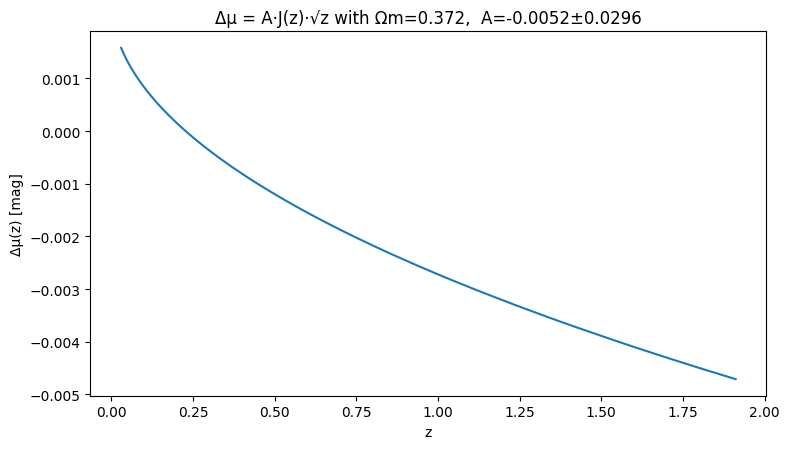

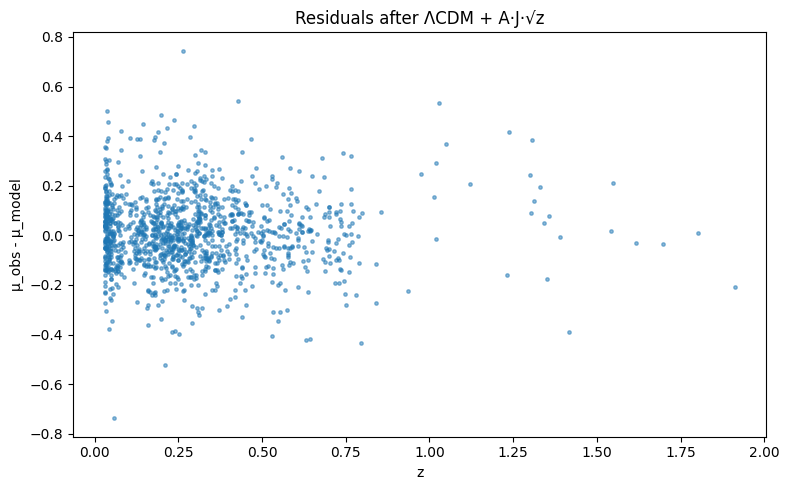

In [12]:
run unimetry_fit_jsqrtz.py


Config: OMEGA_K = -0.2500, Z_MIN = 0.030, FREEZE_OM_TO_LCDM = True
Loaded 1232 SNe from Pantheon+SH0ES.dat
Using z from 'zHD', mu-like from 'MU_SH0ES', sigma from 'MU_SH0ES_ERR_DIAG'
Including peculiar-velocity error from 'VPECERR', z clip 0.003

=== RESULTS ===
LCDM (Ωk=-0.250):  chi2=515.3, dof=1230, chi2_red=0.419, AIC=519.3, BIC=529.6
J√z (Ωm fixed to ΛCDM best-fit, Ωk=-0.250):
  Om=0.453,  A=+0.0061 ± 0.0054 mag
  chi2=514.1, dof=1229, chi2_red=0.418, AIC=520.1, BIC=535.4
Δχ² (ΛCDM → J√z) = 1.25 for -1 params
Saved: jsqrtz_curved_dmu.png, jsqrtz_curved_resid.png


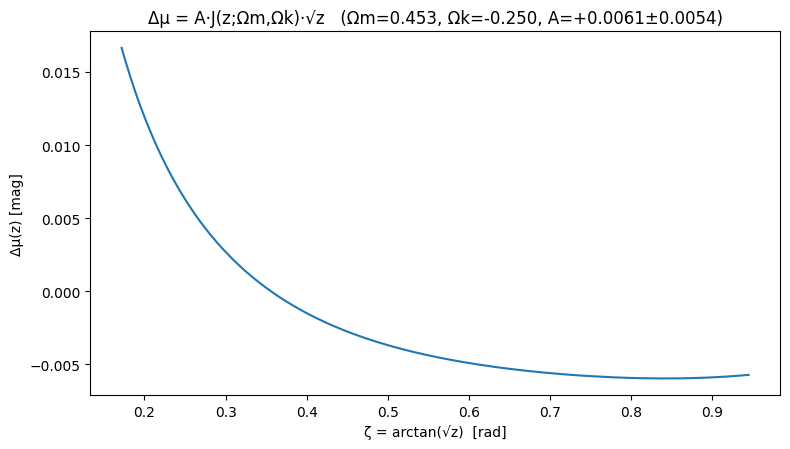

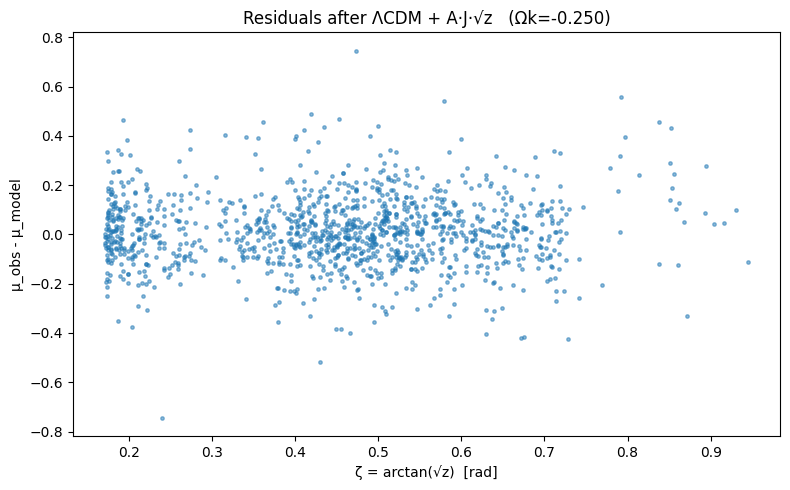

In [23]:
"""
Unimetry SN Fit — curvature-aware J(z; Ωm, Ωk) * √z template
(HD 'instant turn + immediate renormalization' phenomenology)

What this script does
---------------------
1) Loads Pantheon+SH0ES.dat (robust column autodetect).
2) Applies a low-z cut (to suppress peculiar-velocity systematics).
3) Baseline ΛCDM fit with curvature fixed to Ωk=OMEGA_K:
   - Fit Ωm on a grid, solve M analytically, keep ΩΛ = 1-Ωm-Ωk.
4) 1-parameter template fit Δμ(z) = A · f(z) with
   f(z) = J(z;Ωm,Ωk) · √z,  where
   J(z;Ωm,Ωk) = 1 + ((1+z)/E) * [S_k'(D_C)/S_k(D_C)],
   E^2 = Ωm(1+z)^3 + Ωk(1+z)^2 + ΩΛ,   D_C = ∫ dz/E.
   Two modes:
     (A) Ωm fixed to the baseline ΛCDM best-fit (FREEZE_OM_TO_LCDM=True)
     (B) Ωm refit jointly with A (grid over Ωm) (FREEZE_OM_TO_LCDM=False)
   f(z) is weighted-centered to remove degeneracy with M.
5) Prints χ², dof, χ²_red, AIC/BIC, Δχ² vs ΛCDM, A±σ(A).
6) Saves plots: Δμ(z) curve and residuals after ΛCDM+template.

Configuration
-------------
- Set OMEGA_K for curvature: 0 (flat), <0 (closed, 3-sphere), >0 (open).
- Tweak Z_MIN, PREFER_ZHD, ADD_PEC_ERR as needed.

Outputs
-------
- jsqrtz_curved_dmu.png
- jsqrtz_curved_resid.png

Run:
-----
python unimetry_fit_jsqrtz_curved.py
"""
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from pathlib import Path

# ----------------- Config -----------------
DATA_PATH = Path("./Pantheon+SH0ES.dat")
Z_MIN = 0.03         # low-z cut (try 0.02–0.05)
PREFER_ZHD = True    # prefer zHD instead of zCMB
ADD_PEC_ERR = True   # add peculiar-velocity error if available
PEC_Z_CLIP = 0.003   # avoid blow-up at z~0 in σ_μ,pec
SIGMA_FLOOR = 0.12   # minimal σ_μ if missing

# Template fitting options
FREEZE_OM_TO_LCDM = True           # True: fix Ωm to baseline; False: refit with A
OM_GRID = np.linspace(0.05, 0.6, 241)
H0 = 70.0                          # km/s/Mpc (affects zero-point only via M)

# --- Curvature (FRW) ---
OMEGA_K = -0.25   # =0 flat, <0 closed (3-sphere), >0 open

SUPPRESS_WARNINGS = True
if SUPPRESS_WARNINGS:
    warnings.simplefilter("ignore", category=DeprecationWarning)

c_km_s = 299792.458
# --- HD angle & helpers ---
def z_to_zeta(z):
    z = np.asarray(z, float)
    return np.arctan(np.sqrt(np.clip(z, 0, None)))

# -------------- I/O helpers --------------
def _read_any(path: Path) -> pd.DataFrame:
    try:
        df = pd.read_table(path, comment='#', sep=r"\s+", engine="python")
        if len(df.columns) == 1:
            df = pd.read_csv(path, comment='#')
        return df
    except Exception:
        try:
            return pd.read_csv(path, comment='#')
        except Exception:
            return pd.read_csv(path, delim_whitespace=True, comment='#')

def load_sn_table(path: Path):
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")
    df = _read_any(path)
    if len(df.columns) == 1:
        df = pd.read_table(path, comment='#', sep=r"\s+", engine="python")

    cols_lower = {c.lower().strip(): c for c in df.columns}
    def pick(*names):
        for n in names:
            key = n.lower()
            if key in cols_lower:
                return cols_lower[key]
        return None

    # Choose z column
    if PREFER_ZHD:
        zcol = pick('zhd','zcmb','z')
    else:
        zcol = pick('zcmb','zhd','z')
    mucol  = pick('mu','mu_sh0es','distmod','m_b_corr','mb_corr','mb','m_b')
    sigcol = pick('mu_err','sigma_mu','mu_sh0es_err_diag','m_b_corr_err_diag','dmu','dmb','merr')
    vperr_col = pick('vpecerr','vpec_err','sigma_vpec')

    if zcol is None or mucol is None:
        raise ValueError(f"Missing essential columns. Have: {list(df.columns)}")

    out = pd.DataFrame()
    out['z'] = df[zcol].astype(float)
    out['mu_like'] = df[mucol].astype(float)

    if sigcol is not None:
        out['sigma_mu'] = df[sigcol].astype(float).clip(lower=SIGMA_FLOOR)
        sigma_src = sigcol
    else:
        out['sigma_mu'] = SIGMA_FLOOR
        sigma_src = f"floor={SIGMA_FLOOR}"

    if ADD_PEC_ERR and (vperr_col is not None):
        zv = np.clip(out['z'].values, PEC_Z_CLIP, None)
        sigma_v = df[vperr_col].astype(float).values
        sigma_mu_pec = (5.0/np.log(10.0)) * (sigma_v / (c_km_s * zv))
        out['sigma_mu'] = np.sqrt(out['sigma_mu'].values**2 + sigma_mu_pec**2)

    out = out.replace([np.inf,-np.inf], np.nan).dropna(subset=['z','mu_like','sigma_mu'])
    out = out[(out['z']>=Z_MIN) & (out['z']<=2.0)].sort_values('z').reset_index(drop=True)

    print(f"Loaded {len(out)} SNe from {path.name}")
    print(f"Using z from '{zcol}', mu-like from '{mucol}', sigma from '{sigma_src}'")
    if ADD_PEC_ERR and (vperr_col is not None):
        print(f"Including peculiar-velocity error from '{vperr_col}', z clip {PEC_Z_CLIP}")
    return out

# --------- Cosmology with curvature ---------
def E_z(z, Om, Ok, Ol):
    """E(z) = H(z)/H0 for FRW with curvature (Ωk can be ±)."""
    z = np.asarray(z, float)
    return np.sqrt(Om*(1+z)**3 + Ok*(1+z)**2 + Ol)

def DC_dimless(z, Om, Ok, Ol, Nint=800):
    """Dimensionless line-of-sight comoving distance D_C = ∫0^z dz'/E(z')."""
    z = float(z)
    if z <= 0: return 0.0
    zg = np.linspace(0.0, z, Nint)
    Ez = E_z(zg, Om, Ok, Ol)
    return np.trapz(1.0/np.maximum(Ez, 1e-12), zg)

def S_k(x, Ok):
    """Transverse comoving kernel S_k(x) in dimensionless units."""
    if np.isclose(Ok, 0.0):
        return x
    s = np.sqrt(abs(Ok))
    if Ok > 0:
        return np.sinh(s*x)/s
    else:
        return np.sin(s*x)/s

def Skp_over_Sk(x, Ok):
    """Ratio S_k'(x)/S_k(x), stable for small x."""
    tiny = 1e-12
    if np.isclose(Ok, 0.0):
        return 1.0/max(x, tiny)
    s = np.sqrt(abs(Ok))
    sx = s*x
    if Ok > 0:
        return s*np.cosh(sx)/max(np.sinh(sx), tiny)  # s*coth(sx)
    else:
        return s*np.cos(sx)/max(np.sin(sx), tiny)    # s*cot(sx)

def lum_distance(z, Om, Ok, Ol, H0=H0):
    """
    D_L (Mpc) = (c/H0) * (1+z) * S_k(D_C),
    where D_C = ∫ dz/E (dimensionless), S_k — dimensionless kernel.
    """
    z = np.atleast_1d(z).astype(float)
    DC = np.array([DC_dimless(zi, Om, Ok, Ol) for zi in z])
    DM = np.array([S_k(DCi, Ok) for DCi in DC])
    DL = (c_km_s/H0) * (1.0 + z) * DM  # Mpc
    return DL if DL.ndim else float(DL)

def mu_theory(z, Om, Ok, Ol, M0):
    Dl = lum_distance(z, Om, Ok, Ol, H0=H0)
    return 5.0*np.log10(np.clip(Dl, 1e-9, None)) + 25.0 + M0

def J_sensitivity(z, Om, Ok, Ol):
    """
    J = d ln D_L / d ln(1+z) = 1 + ((1+z)/E) * [S_k'(D_C)/S_k(D_C)],
    with D_C = ∫ dz/E — dimensionless.
    """
    z = np.asarray(z, float)
    Ez  = E_z(z, Om, Ok, Ol)
    DC  = np.array([DC_dimless(zi, Om, Ok, Ol) for zi in z])
    ratio = np.array([Skp_over_Sk(DCi, Ok) for DCi in DC])  # S_k'/S_k
    with np.errstate(divide='ignore', invalid='ignore'):
        J = 1.0 + ((1.0+z)/np.maximum(Ez, 1e-12)) * ratio
    # Guard for z→0
    J[~np.isfinite(J)] = 2.0
    return J

# --------------- Baseline ΛCDM fit ---------------
def fit_lcdm(sn, Om_grid=OM_GRID):
    z = sn['z'].values
    y = sn['mu_like'].values
    w = 1.0/(sn['sigma_mu'].values**2)
    best=None
    for Om in Om_grid:
        Ok = OMEGA_K
        Ol = 1.0 - Om - Ok
        mu0 = mu_theory(z, Om, Ok, Ol, M0=0.0)
        M = np.sum(w*(y-mu0))/np.sum(w)
        r = y - (mu0 + M)
        chi2 = np.sum(w*r*r)
        if best is None or chi2<best['chi2']:
            best={'Om':float(Om),'Ok':float(Ok),'Ol':float(Ol),'M':float(M),'chi2':float(chi2)}
    N = len(y); k = 2
    best['dof']=int(N-k); best['chi2_red']=best['chi2']/max(1,best['dof'])
    best['AIC'] = best['chi2'] + 2*k
    best['BIC'] = best['chi2'] + k*np.log(N)
    return best

# -------- Template fit: Δμ = A · J(z;Ωm,Ωk) · √z --------
def fit_jsqrtz(sn, Om_grid=OM_GRID, freeze_Om_to=None):
    z = sn['z'].values
    y = sn['mu_like'].values
    w = 1.0/(sn['sigma_mu'].values**2)
    best=None
    Om_list = [float(freeze_Om_to)] if (freeze_Om_to is not None) else Om_grid

    for Om in Om_list:
        Ok = OMEGA_K
        Ol = 1.0 - Om - Ok
        mu0 = mu_theory(z, Om, Ok, Ol, M0=0.0)

        J  = J_sensitivity(z, Om, Ok, Ol)
        f  = J * np.sqrt(np.clip(z,0,None))
        f  = f - np.average(f, weights=w)  # weighted centering

        X = np.column_stack([np.ones_like(z), f])  # [M, A]
        W = np.diag(w)
        A_mat = X.T @ W @ X
        b_vec = X.T @ W @ (y - mu0)
        theta = np.linalg.solve(A_mat, b_vec)
        M_hat, A_hat = float(theta[0]), float(theta[1])

        resid = y - (mu0 + M_hat + A_hat*f)
        chi2  = float(np.sum(w*resid*resid))
        cov   = np.linalg.inv(A_mat)
        sigA  = float(np.sqrt(cov[1,1]))

        if (best is None) or (chi2<best['chi2']):
            best={'Om':float(Om),'Ok':float(Ok),'Ol':float(Ol),'M':M_hat,'A':A_hat,'sigma_A':sigA,
                  'chi2':chi2,'f':f,'resid':resid}

    N = len(y); k = 3  # counting [M, A, Ωm] effectively; Ωk fixed by config
    best['dof']=int(N-k); best['chi2_red']=best['chi2']/max(1,best['dof'])
    best['AIC'] = best['chi2'] + 2*k
    best['BIC'] = best['chi2'] + k*np.log(N)
    return best

# ------------------- Plots -------------------
def plot_jsqrtz(sn, lcdm, templ, prefix="jsqrtz_curved"):
    z = sn['z'].values; y = sn['mu_like'].values
    Om, Ok, Ol = templ['Om'], templ['Ok'], templ['Ol']

    J  = J_sensitivity(z, Om, Ok, Ol)
    f  = J * np.sqrt(np.clip(z,0,None))
    f  = f - np.average(f, weights=1.0/(sn['sigma_mu'].values**2))

    mu0 = mu_theory(z, Om, Ok, Ol, M0=0.0)
    muT = mu0 + templ['M'] + templ['A']*f

    # Δμ(z)
    idx = np.argsort(z)
    plt.figure(figsize=(8,4.6))
    plt.plot(z_to_zeta(z[idx]), (templ['A']*f)[idx])
    plt.xlabel("ζ = arctan(√z)  [rad]"); plt.ylabel("Δμ(z) [mag]")
    plt.title(f"Δμ = A·J(z;Ωm,Ωk)·√z   (Ωm={Om:.3f}, Ωk={Ok:+.3f}, A={templ['A']:+.4f}±{templ['sigma_A']:.4f})")
    plt.tight_layout(); plt.savefig(f"{prefix}_dmu.png", dpi=160)

    # Residuals after template
    plt.figure(figsize=(8,5))
    plt.scatter(z_to_zeta(z) , y - muT, s=6, alpha=0.5)
    plt.xlabel("ζ = arctan(√z)  [rad]"); plt.ylabel("μ_obs - μ_model")
    plt.title(f"Residuals after ΛCDM + A·J·√z   (Ωk={Ok:+.3f})")
    plt.tight_layout(); plt.savefig(f"{prefix}_resid.png", dpi=160)

# -------------------- Main --------------------
def main():
    print(f"Config: OMEGA_K = {OMEGA_K:+.4f}, Z_MIN = {Z_MIN:.3f}, FREEZE_OM_TO_LCDM = {FREEZE_OM_TO_LCDM}")
    sn = load_sn_table(DATA_PATH)
    lcdm = fit_lcdm(sn)

    if FREEZE_OM_TO_LCDM:
        templ = fit_jsqrtz(sn, freeze_Om_to=lcdm['Om'])
        mode = "Ωm fixed to ΛCDM best-fit"
    else:
        templ = fit_jsqrtz(sn)
        mode = "Ωm refit jointly with A"

    print("\n=== RESULTS ===")
    print(f"LCDM (Ωk={lcdm['Ok']:+.3f}):  chi2={lcdm['chi2']:.1f}, dof={lcdm['dof']}, chi2_red={lcdm['chi2_red']:.3f}, AIC={lcdm['AIC']:.1f}, BIC={lcdm['BIC']:.1f}")
    print(f"J√z ({mode}, Ωk={templ['Ok']:+.3f}):")
    print(f"  Om={templ['Om']:.3f},  A={templ['A']:+.4f} ± {templ['sigma_A']:.4f} mag")
    print(f"  chi2={templ['chi2']:.1f}, dof={templ['dof']}, chi2_red={templ['chi2_red']:.3f}, AIC={templ['AIC']:.1f}, BIC={templ['BIC']:.1f}")
    print(f"Δχ² (ΛCDM → J√z) = {lcdm['chi2']-templ['chi2']:.2f} for {templ['dof']-lcdm['dof']:+d} params")

    plot_jsqrtz(sn, lcdm, templ, prefix="jsqrtz_curved")
    print("Saved: jsqrtz_curved_dmu.png, jsqrtz_curved_resid.png")

if __name__ == "__main__":
    main()


Loaded 1700 SNe from Pantheon+SH0ES.dat
Using z from 'zCMB', mu-like from 'MU_SH0ES', sigma from 'MU_SH0ES_ERR_DIAG'
Including peculiar-velocity error from 'VPECERR', z clip 0.003

Projection onto f(ζ)=J·√z:
  A = +0.00360 ± 0.00264 mag
  Δχ² (vs A=0) = 1.86   [χ²_null=743.6 → χ²=741.8]
Saved: zeta_proj_jsqrtz_dmu.png, zeta_proj_jsqrtz_resid.png
Baseline ΛCDM fit (Ωk fixed):
  Ωm=0.375, Ωk=+0.000, ΩΛ=0.625, M=-0.076
  χ²=743.6, dof=1698, χ²_red=0.438
Saved: zeta_density.png, zeta_meanvar.png, zeta_acf_ljungbox.png
Interpretation guide:
 (1) If ρ̂(ζ) is flatter than raw counts, Jacobian explains part of non-uniformity.
 (2) If slope of ⟨resid⟩(ζ) ~ 0 and var(resid) is flat across ζ, residuals are stationary in ζ.
 (4) If ACF is within noise and Ljung–Box p-values are not small, residuals are 'white' in ζ-order.


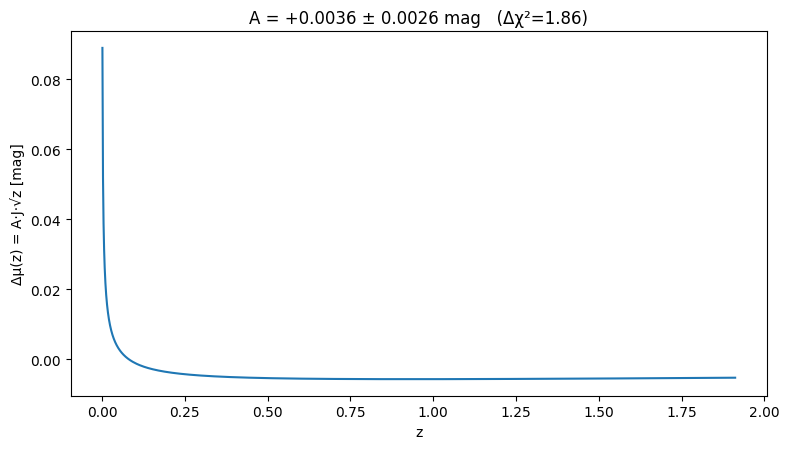

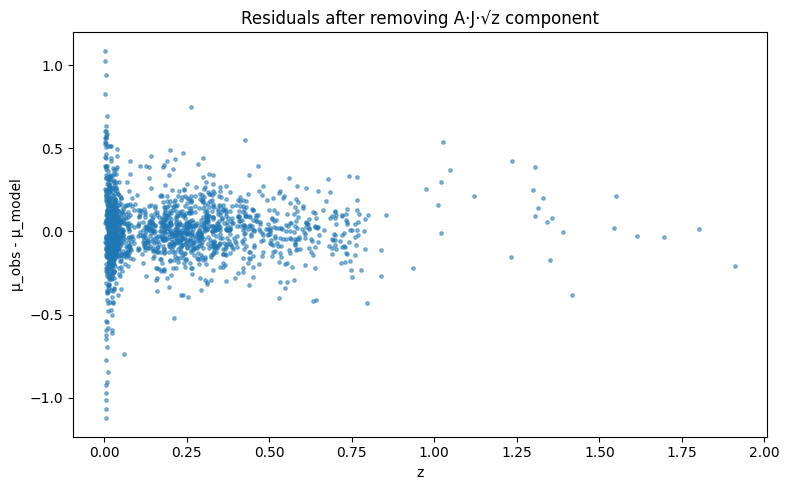

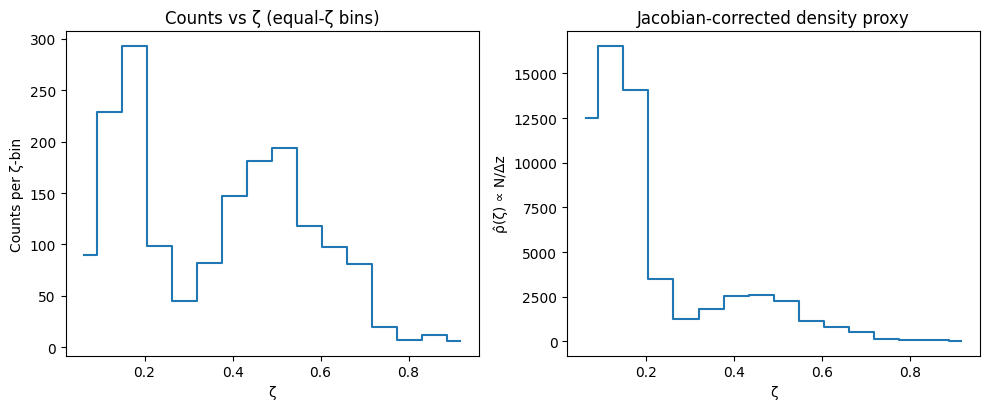

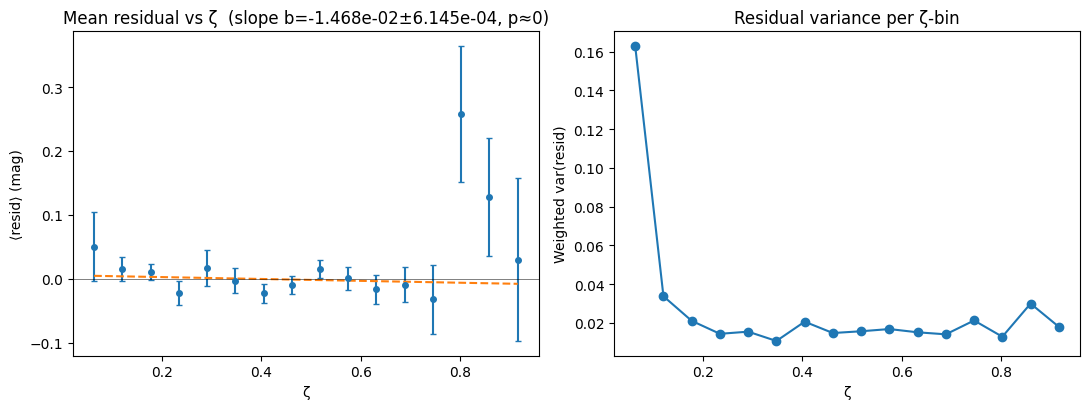

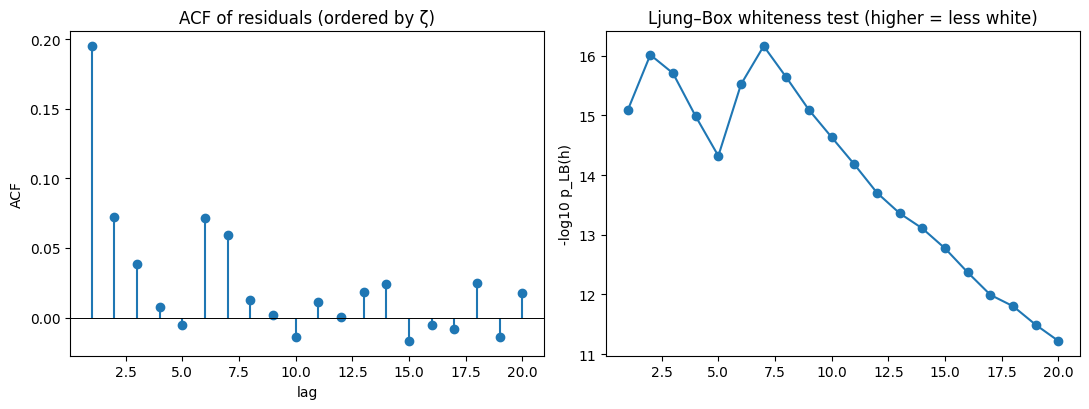

In [41]:
"""
Unimetry residual diagnostics in ζ (half-dilation angle) — tests (1), (2), (4)

Что делает
----------
1) Переводит z -> ζ по z = tan^2 ζ (ζ = arctan sqrt z).
   Строит:
   - счётчики N(ζ) в равных ζ-корзинах;
   - «якобиан-исправленную» плотность ρ̂(ζ) ∝ N / Δz (Δz внутри ζ-бинна).
2) Тест стационарности остатка r = μ_obs − μ_LCDM:
   - ⟨r⟩ с SE и взвешенная регрессия ⟨r⟩(ζ) → наклон, p-value;
   - взвешенная дисперсия var_w(r) по ζ-биннам.
4) Тест «белизны» по ζ:
   - ACF(lag) остатка, упорядоченного по ζ;
   - Ljung–Box Q(h) и p-values (если есть SciPy).

Базовая модель
--------------
Фит плоской/криволинейной ΛCDM (Ωk фиксирован): скан Ωm по сетке, ΩΛ=1−Ωm−Ωk,
аналитическое M. Остатки считаются от лучшей модели.

Выходные файлы
--------------
- zeta_density.png         (Counts vs ζ и ρ̂(ζ) ∝ N/Δz)
- zeta_meanvar.png         (⟨resid⟩±SE и var per ζ-bin, slope+p)
- zeta_acf_ljungbox.png    (ACF и −log10 p_LB(h) по лагу)

Запуск
------
python unimetry_resid_tests_zeta.py
"""

import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from pathlib import Path

# ===================== CONFIG =====================
DATA_PATH   = Path("./Pantheon+SH0ES.dat")
Z_MIN, Z_MAX = 0.0, 2.0
PREFER_ZHD  = False            # True -> zHD вместо zCMB
H0          = 70.0            # km/s/Mpc (в нуль-уровне M)
OMEGA_K     = 0.0             # 0 плоская; <0 закрытая (3-сфера); >0 открытая
OM_GRID     = np.linspace(0.05, 0.6, 241)

NBINS_ZETA  = 16              # число равных ζ-корзин
PEC_Z_CLIP  = 0.003           # срез при добавке vpec в σμ
ADD_PEC_ERR = True
SIGMA_FLOOR = 0.12            # fallback σμ, если нет столбца

SUPPRESS_WARNINGS = True
if SUPPRESS_WARNINGS:
    warnings.simplefilter("ignore", category=DeprecationWarning)

c_km_s = 299792.458

# ===================== I/O =======================
def _read_any(path: Path) -> pd.DataFrame:
    try:
        df = pd.read_table(path, comment='#', sep=r"\s+", engine="python")
        if len(df.columns) == 1:
            df = pd.read_csv(path, comment='#')
        return df
    except Exception:
        try:
            return pd.read_csv(path, comment='#')
        except Exception:
            return pd.read_csv(path, delim_whitespace=True, comment='#')

def load_sn_table(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")
    df = _read_any(path)
    if len(df.columns) == 1:
        df = pd.read_table(path, comment='#', sep=r"\s+", engine="python")

    cols_lower = {c.lower().strip(): c for c in df.columns}
    def pick(*names):
        for n in names:
            key = n.lower()
            if key in cols_lower:
                return cols_lower[key]
        return None

    # столбцы
    if PREFER_ZHD:
        zcol = pick('zhd','zcmb','z')
    else:
        zcol = pick('zcmb','zhd','z')
    mucol  = pick('mu','mu_sh0es','distmod','m_b_corr','mb_corr','mb','m_b')
    sigcol = pick('mu_err','sigma_mu','mu_sh0es_err_diag','m_b_corr_err_diag','dmu','dmb','merr')
    vperr_col = pick('vpecerr','vpec_err','sigma_vpec')

    if zcol is None or mucol is None:
        raise ValueError(f"Missing essential columns. Have: {list(df.columns)}")

    out = pd.DataFrame()
    out['z'] = df[zcol].astype(float)
    out['mu_like'] = df[mucol].astype(float)

    if sigcol is not None:
        out['sigma_mu'] = df[sigcol].astype(float).clip(lower=SIGMA_FLOOR)
        sigma_src = sigcol
    else:
        out['sigma_mu'] = SIGMA_FLOOR
        sigma_src = f"floor={SIGMA_FLOOR}"

    if ADD_PEC_ERR and (vperr_col is not None):
        zv = np.clip(out['z'].values, PEC_Z_CLIP, None)
        sigma_v = df[vperr_col].astype(float).values
        sigma_mu_pec = (5.0/np.log(10.0)) * (sigma_v / (c_km_s * zv))
        out['sigma_mu'] = np.sqrt(out['sigma_mu'].values**2 + sigma_mu_pec**2)

    out = out.replace([np.inf,-np.inf], np.nan).dropna(subset=['z','mu_like','sigma_mu'])
    out = out[(out['z']>=Z_MIN) & (out['z']<=Z_MAX)].sort_values('z').reset_index(drop=True)

    print(f"Loaded {len(out)} SNe from {path.name}")
    print(f"Using z from '{zcol}', mu-like from '{mucol}', sigma from '{sigma_src}'")
    if ADD_PEC_ERR and (vperr_col is not None):
        print(f"Including peculiar-velocity error from '{vperr_col}', z clip {PEC_Z_CLIP}")
    return out

# ============= Космология с кривизной =============
def E_z(z, Om, Ok, Ol):
    z = np.asarray(z, float)
    return np.sqrt(Om*(1+z)**3 + Ok*(1+z)**2 + Ol)

def DC_dimless(z, Om, Ok, Ol, Nint=800):
    z = float(z)
    if z <= 0: return 0.0
    zg = np.linspace(0.0, z, Nint)
    Ez = E_z(zg, Om, Ok, Ol)
    return np.trapz(1.0/np.maximum(Ez, 1e-12), zg)

def S_k(x, Ok):
    if np.isclose(Ok, 0.0):
        return x
    s = np.sqrt(abs(Ok))
    if Ok > 0:
        return np.sinh(s*x)/s
    else:
        return np.sin(s*x)/s

def lum_distance(z, Om, Ok, Ol, H0=H0):
    z = np.atleast_1d(z).astype(float)
    DC = np.array([DC_dimless(zi, Om, Ok, Ol) for zi in z])
    DM = np.array([S_k(DCi, Ok) for DCi in DC])
    DL = (c_km_s/H0) * (1.0 + z) * DM
    return DL if DL.ndim else float(DL)

def mu_theory(z, Om, Ok, Ol, M0):
    Dl = lum_distance(z, Om, Ok, Ol, H0=H0)
    return 5.0*np.log10(np.clip(Dl, 1e-9, None)) + 25.0 + M0

# ---- J-sensitivity with curvature ----
def Skp_over_Sk(x, Ok):
    """S_k'(x)/S_k(x) — устойчиво при малых x."""
    tiny = 1e-12
    if np.isclose(Ok, 0.0):
        return 1.0/max(x, tiny)
    s = np.sqrt(abs(Ok))
    sx = s*x
    if Ok > 0:
        # d/dx sinh(sx)/s = cosh(sx); /S_k = s*coth(sx)
        return s*np.cosh(sx)/max(np.sinh(sx), tiny)
    else:
        # d/dx sin(sx)/s = cos(sx); /S_k = s*cot(sx)
        return s*np.cos(sx)/max(np.sin(sx), tiny)

def J_sensitivity(z, Om, Ok, Ol):
    """
    J = d ln D_L / d ln(1+z) = 1 + ((1+z)/E) * [S_k'(D_C)/S_k(D_C)],
    где D_C = ∫ dz/E — безразмерное.
    """
    z = np.asarray(z, float)
    Ez  = E_z(z, Om, Ok, Ol)
    DC  = np.array([DC_dimless(zi, Om, Ok, Ol) for zi in z])
    ratio = np.array([Skp_over_Sk(DCi, Ok) for DCi in DC])
    with np.errstate(divide='ignore', invalid='ignore'):
        J = 1.0 + ((1.0+z)/np.maximum(Ez, 1e-12)) * ratio
    J[~np.isfinite(J)] = 2.0
    return J

# ---- Projection of residuals onto f(ζ)=J·tanζ ≡ J·√z ----
def project_jsqrtz_amplitude(z, resid, sigma_mu, Om, Ok, Ol, center_f=True):
    """
    Возвращает словарь с оценкой A, её ошибкой и Δχ²:
      r ≈ A · f,  f = J(z;Om,Ok,Ol) * sqrt(z).
    """
    z = np.asarray(z, float)
    r = np.asarray(resid, float)
    w = 1.0/np.maximum(sigma_mu, 1e-9)**2

    J = J_sensitivity(z, Om, Ok, Ol)
    f = J * np.sqrt(np.clip(z, 0, None))
    if center_f:
        f = f - np.average(f, weights=w)   # убираем моду с M

    # Взвешенная проекция (без свободного смещения):
    denom = np.sum(w*f*f)
    A_hat = np.sum(w*f*r) / np.maximum(denom, 1e-30)
    sigma_A = 1.0 / np.sqrt(np.maximum(denom, 1e-30))

    chi2_null  = float(np.sum(w*r*r))
    chi2_model = float(np.sum(w*(r - A_hat*f)**2))
    delta_chi2 = chi2_null - chi2_model

    return dict(A=A_hat, sigma_A=sigma_A, chi2=chi2_model,
                chi2_null=chi2_null, delta_chi2=delta_chi2, f=f, J=J)

def plot_jsqrtz_projection(z, y, mu0, proj, out_prefix="zeta_proj_jsqrtz"):
    """
    Рисует Δμ(z)=A·f(z) и остатки после вычитания компоненты A·f.
    """
    A = proj['A']; f = proj['f']
    muT = mu0 + A*f

    idx = np.argsort(z)
    plt.figure(figsize=(8,4.6))
    plt.plot(z[idx], (A*f)[idx])
    plt.xlabel("z"); plt.ylabel("Δμ(z) = A·J·√z [mag]")
    plt.title(f"A = {A:+.4f} ± {proj['sigma_A']:.4f} mag   (Δχ²={proj['delta_chi2']:.2f})")
    plt.tight_layout(); plt.savefig(out_prefix+"_dmu.png", dpi=160)

    plt.figure(figsize=(8,5))
    plt.scatter(z, y - muT, s=6, alpha=0.5)
    plt.xlabel("z"); plt.ylabel("μ_obs - μ_model")
    plt.title("Residuals after removing A·J·√z component")
    plt.tight_layout(); plt.savefig(out_prefix+"_resid.png", dpi=160)


# ============== Фит базового ΛCDM ================
def fit_lcdm(sn, Om_grid=OM_GRID):
    z = sn['z'].values
    y = sn['mu_like'].values
    w = 1.0/(sn['sigma_mu'].values**2)
    best=None
    for Om in Om_grid:
        Ok = OMEGA_K
        Ol = 1.0 - Om - Ok
        mu0 = mu_theory(z, Om, Ok, Ol, M0=0.0)
        M = np.sum(w*(y-mu0))/np.sum(w)
        resid = y - (mu0 + M)
        chi2 = np.sum(w*resid*resid)
        if (best is None) or (chi2 < best['chi2']):
            best={'Om':float(Om),'Ok':float(Ok),'Ol':float(Ol),'M':float(M),
                  'chi2':float(chi2),'resid':resid, 'mu0':mu0}
    N=len(y); k=2
    best['dof']=int(N-k); best['chi2_red']=best['chi2']/max(1,best['dof'])
    return best

# ============== ζ-параметризация =================
def z_to_zeta(z):
    z = np.asarray(z, float)
    return np.arctan(np.sqrt(np.clip(z,0,None)))

def jacobian_dz_dzeta(z):
    z = np.asarray(z, float)
    return 2.0*np.sqrt(np.clip(z,0,None))*(1.0+z)

# ============== Бины и статистики =================
def binned_stats_zeta(z, resid, sigma, nbins=NBINS_ZETA):
    z = np.asarray(z); resid = np.asarray(resid); sigma = np.asarray(sigma)
    zeta = z_to_zeta(z)
    w = 1.0/np.maximum(sigma,1e-9)**2

    zeta_min, zeta_max = zeta.min(), zeta.max()
    edges = np.linspace(zeta_min, zeta_max, nbins+1)
    centers = 0.5*(edges[:-1]+edges[1:])
    N = np.zeros(nbins, dtype=int)
    mean = np.zeros(nbins); se = np.zeros(nbins); varw = np.zeros(nbins)
    dz_span = np.zeros(nbins)

    for j in range(nbins):
        if j < nbins-1:
            m = (zeta>=edges[j]) & (zeta<edges[j+1])
        else:
            m = (zeta>=edges[j]) & (zeta<=edges[j+1])
        N[j] = int(m.sum())
        if N[j]>0:
            wj = w[m]; rj = resid[m]; zj = z[m]
            W = np.sum(wj)
            mu = np.sum(wj*rj)/W
            mean[j] = mu
            se[j] = np.sqrt(1.0/np.maximum(W,1e-12))
            varw[j] = np.sum(wj*(rj-mu)**2)/W
            dz_span[j] = (zj.max()-zj.min()) if N[j]>1 else np.nan
        else:
            mean[j]=np.nan; se[j]=np.nan; varw[j]=np.nan; dz_span[j]=np.nan

    # ρ̂(ζ) ∝ N / Δz (аппроксимация ∫ J_zeta dζ = Δz)
    rho = np.full(nbins, np.nan)
    for j in range(nbins):
        if N[j]>0 and np.isfinite(dz_span[j]) and dz_span[j]>0:
            rho[j] = N[j]/dz_span[j]
    return dict(edges=edges, centers=centers, N=N, mean=mean, se=se, varw=varw, rho=rho)

# ============== Регрессия и «белизна» ============
def weighted_linreg(x, y, w):
    """Взвешенная лин.регрессия y=a+b x. Возвращает (a,b, sigma_b, t_b, p≈)."""
    x = np.asarray(x, float); y = np.asarray(y, float); w = np.asarray(w, float)
    m = np.isfinite(x) & np.isfinite(y) & np.isfinite(w) & (w>0)
    x, y, w = x[m], y[m], w[m]
    if len(x) < 3:
        return np.nan, np.nan, np.nan, np.nan, np.nan
    W = np.sum(w); xbar = np.sum(w*x)/W; ybar = np.sum(w*y)/W
    Sxx = np.sum(w*(x-xbar)**2)
    Sxy = np.sum(w*(x-xbar)*(y-ybar))
    b = Sxy/np.maximum(Sxx,1e-30)
    a = ybar - b*xbar
    r = y - (a + b*x)
    # консервативная оценка s^2
    s2 = np.sum(w*r*r)/W
    sigma_b = np.sqrt(s2/np.maximum(Sxx,1e-30))
    t_b = b/np.maximum(sigma_b,1e-30)
    # двухсторонний p (норм. аппроксимация)
    from math import erf, sqrt
    p = 2*(1-0.5*(1+erf(abs(t_b)/sqrt(2))))
    return a,b,sigma_b,t_b,p

def acf_series(x, nlags=20):
    x = np.asarray(x, float)
    x = x - np.nanmean(x)
    n = len(x)
    if n < 2:
        return np.full(nlags, np.nan)
    ac = []
    var = np.nanvar(x)
    for k in range(1, nlags+1):
        if n-k <= 1 or var <= 0:
            ac.append(np.nan)
        else:
            num = np.nansum(x[:n-k]*x[k:])
            ac.append(num/((n-k)*var))
    return np.array(ac)

def ljung_box_Q(ac, n):
    """Q(h) для h=1..len(ac)."""
    h = np.arange(1, len(ac)+1)
    with np.errstate(divide='ignore', invalid='ignore'):
        Q = n*(n+2)*np.cumsum(np.nan_to_num(ac)**2/np.maximum(n-h,1))
    return Q

def chi2_sf(x, k):
    """хвостовая вероятность χ²_k. SciPy если есть, иначе None."""
    try:
        import scipy.stats as st
        return st.chi2.sf(x, k)
    except Exception:
        return None

# ===================== ПЛОТЫ =====================
def plot_density(bins, out_prefix="zeta_density"):
    zc = bins['centers']; N = bins['N']; rho = bins['rho']
    fig, ax = plt.subplots(1,2, figsize=(10,4.2), sharex=False)
    ax[0].step(zc, N, where='mid')
    ax[0].set_xlabel("ζ"); ax[0].set_ylabel("Counts per ζ-bin")
    ax[0].set_title("Counts vs ζ (equal-ζ bins)")
    ax[1].step(zc, rho, where='mid')
    ax[1].set_xlabel("ζ"); ax[1].set_ylabel("ρ̂(ζ) ∝ N/Δz")
    ax[1].set_title("Jacobian-corrected density proxy")
    fig.tight_layout(); fig.savefig(out_prefix+".png", dpi=160)

def plot_meanvar(bins, out_prefix="zeta_meanvar"):
    zc = bins['centers']; mean=bins['mean']; se=bins['se']; varw=bins['varw']
    w = 1.0/np.clip(se, 1e-9, None)**2
    a,b,sb,tb,p = weighted_linreg(zc, mean, w)

    fig, ax = plt.subplots(1,2, figsize=(11,4.2))
    ax[0].errorbar(zc, mean, yerr=se, fmt='o', ms=4, capsize=2)
    if np.isfinite(b):
        xx = np.linspace(np.nanmin(zc), np.nanmax(zc), 200)
        ax[0].plot(xx, a + b*xx, ls='--')
    ax[0].axhline(0, color='k', lw=0.7, alpha=0.5)
    ax[0].set_xlabel("ζ"); ax[0].set_ylabel("⟨resid⟩ (mag)")
    ax[0].set_title(f"Mean residual vs ζ  (slope b={b:+.3e}±{sb:.3e}, p≈{p:.3g})")

    ax[1].plot(zc, varw, 'o-')
    ax[1].set_xlabel("ζ"); ax[1].set_ylabel("Weighted var(resid)")
    ax[1].set_title("Residual variance per ζ-bin")

    fig.tight_layout(); fig.savefig(out_prefix+".png", dpi=160)

def plot_acf_lb(resid, z, nlags=20, out_prefix="zeta_acf_ljungbox"):
    # порядок по ζ
    zeta = z_to_zeta(z)
    idx = np.argsort(zeta)
    r = resid[idx]; n = len(r)
    ac = acf_series(r, nlags=nlags)
    Q = ljung_box_Q(ac, n)
    # p-значения, если есть SciPy
    pvals = []
    for h in range(1, nlags+1):
        pv = chi2_sf(Q[h-1], h)
        pvals.append(pv)

    fig, ax = plt.subplots(1,2, figsize=(11,4.2))
    ax[0].stem(np.arange(1, nlags+1), ac, basefmt=" ")
    ax[0].axhline(0, color='k', lw=0.7)
    ax[0].set_xlabel("lag"); ax[0].set_ylabel("ACF")
    ax[0].set_title("ACF of residuals (ordered by ζ)")

    y = np.array([(-np.log10(p) if (p is not None and p>0) else np.nan) for p in pvals])
    ax[1].plot(np.arange(1, nlags+1), y, 'o-')
    ax[1].set_ylabel("-log10 p_LB(h)")
    ax[1].set_title("Ljung–Box whiteness test (higher = less white)")
    fig.tight_layout(); fig.savefig(out_prefix+".png", dpi=160)

# ===================== MAIN ======================
def main():
    sn = load_sn_table(DATA_PATH)
    lcdm = fit_lcdm(sn)
    z = sn['z'].values
    y = sn['mu_like'].values

    mu0 = mu_theory(z, lcdm['Om'], lcdm['Ok'], lcdm['Ol'], M0=lcdm['M'])
    resid = y - mu0

    # === ПРОЕКЦИЯ НА ТЕОРЕТИЧЕСКУЮ ФОРМУ A·J·√z ===
    proj = project_jsqrtz_amplitude(
        z, resid, sn['sigma_mu'].values,
        Om=lcdm['Om'], Ok=lcdm['Ok'], Ol=lcdm['Ol'],
        center_f=True
    )
    print("\nProjection onto f(ζ)=J·√z:")
    print(f"  A = {proj['A']:+.5f} ± {proj['sigma_A']:.5f} mag")
    print(f"  Δχ² (vs A=0) = {proj['delta_chi2']:.2f}   "
          f"[χ²_null={proj['chi2_null']:.1f} → χ²={proj['chi2']:.1f}]")
    
    plot_jsqrtz_projection(z, y, mu0, proj, out_prefix="zeta_proj_jsqrtz")
    print("Saved: zeta_proj_jsqrtz_dmu.png, zeta_proj_jsqrtz_resid.png")


    print("Baseline ΛCDM fit (Ωk fixed):")
    print(f"  Ωm={lcdm['Om']:.3f}, Ωk={lcdm['Ok']:+.3f}, ΩΛ={lcdm['Ol']:.3f}, M={lcdm['M']:+.3f}")
    print(f"  χ²={lcdm['chi2']:.1f}, dof={lcdm['dof']}, χ²_red={lcdm['chi2_red']:.3f}")

    bins = binned_stats_zeta(z, resid, sn['sigma_mu'].values, nbins=NBINS_ZETA)
    plot_density(bins, out_prefix="zeta_density")
    plot_meanvar(bins, out_prefix="zeta_meanvar")
    plot_acf_lb(resid, z, nlags=20, out_prefix="zeta_acf_ljungbox")

    print("Saved: zeta_density.png, zeta_meanvar.png, zeta_acf_ljungbox.png")
    print("Interpretation guide:")
    print(" (1) If ρ̂(ζ) is flatter than raw counts, Jacobian explains part of non-uniformity.")
    print(" (2) If slope of ⟨resid⟩(ζ) ~ 0 and var(resid) is flat across ζ, residuals are stationary in ζ.")
    print(" (4) If ACF is within noise and Ljung–Box p-values are not small, residuals are 'white' in ζ-order.")

if __name__ == "__main__":
    main()


Loaded 1700 SNe from Pantheon+SH0ES.dat
Using z from 'zCMB', mu-like from 'MU_SH0ES', sigma from 'MU_SH0ES_ERR_DIAG'
Including peculiar-velocity error from 'VPECERR', z clip 0.003
Baseline ΛCDM (Ωk fixed):
  Ωm=0.375, Ωk=+0.000, ΩΛ=0.625, M=-0.076
  χ²=743.6, dof=1698, χ²_red=0.438
Saved: z_density.png, z_meanvar.png, z_acf_ljungbox.png


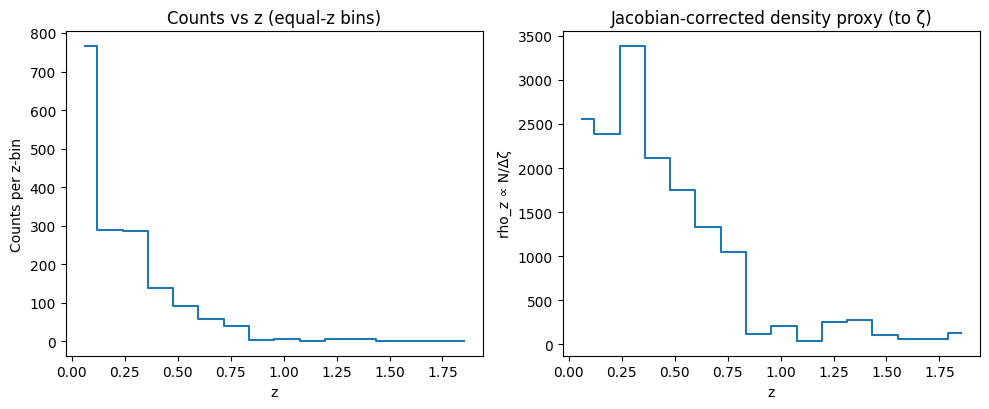

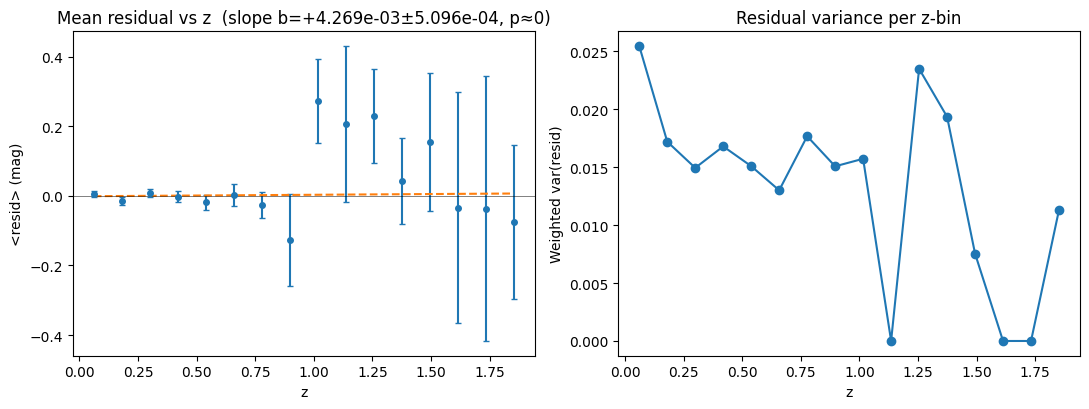

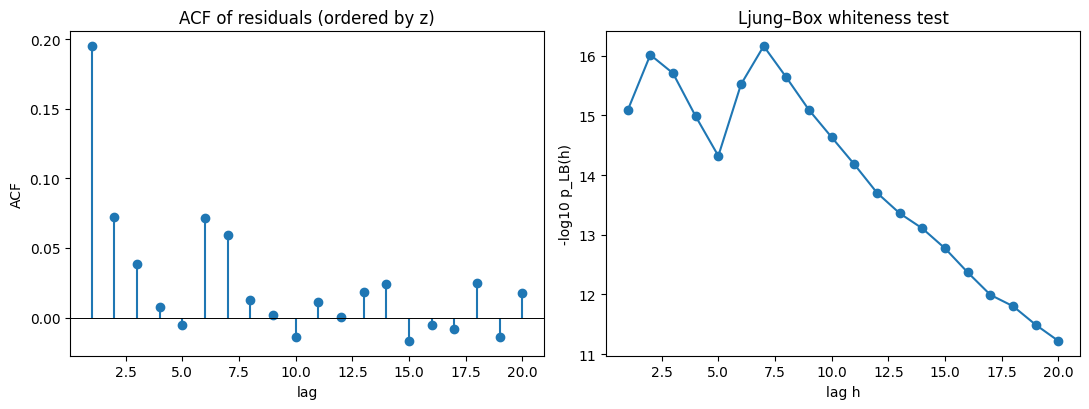

In [40]:
"""
Residual diagnostics in redshift z (ΛCDM baseline):
(1) counts vs z and Jacobian-corrected density N/Δζ,
(2) ⟨resid⟩(z) with slope+p and weighted var per z-bin,
(4) ACF & Ljung–Box of residuals ordered by z.

Outputs:
- z_density.png
- z_meanvar.png
- z_acf_ljungbox.png
"""

import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from pathlib import Path

# ============== CONFIG ==============
DATA_PATH   = Path("./Pantheon+SH0ES.dat")
Z_MIN, Z_MAX = 0.0, 2.0
PREFER_ZHD  = False          # True -> zHD вместо zCMB
H0          = 70.0
OMEGA_K     = 0.0            # 0 flat; <0 closed (3-sphere); >0 open
OM_GRID     = np.linspace(0.05, 0.6, 241)

NBINS_Z     = 16
PEC_Z_CLIP  = 0.003
ADD_PEC_ERR = True
SIGMA_FLOOR = 0.12

SUPPRESS_WARNINGS = True
if SUPPRESS_WARNINGS:
    warnings.simplefilter("ignore", category=DeprecationWarning)

c_km_s = 299792.458

# ============== I/O ==============
def _read_any(path: Path) -> pd.DataFrame:
    try:
        df = pd.read_table(path, comment='#', sep=r"\s+", engine="python")
        if len(df.columns) == 1:
            df = pd.read_csv(path, comment='#')
        return df
    except Exception:
        try:
            return pd.read_csv(path, comment='#')
        except Exception:
            return pd.read_csv(path, delim_whitespace=True, comment='#')

def load_sn_table(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")
    df = _read_any(path)
    if len(df.columns) == 1:
        df = pd.read_table(path, comment='#', sep=r"\s+", engine="python")

    cols_lower = {c.lower().strip(): c for c in df.columns}
    def pick(*names):
        for n in names:
            k = n.lower()
            if k in cols_lower: return cols_lower[k]
        return None

    if PREFER_ZHD:
        zcol = pick('zhd','zcmb','z')
    else:
        zcol = pick('zcmb','zhd','z')
    mucol  = pick('mu','mu_sh0es','distmod','m_b_corr','mb_corr','mb','m_b')
    sigcol = pick('mu_err','sigma_mu','mu_sh0es_err_diag','m_b_corr_err_diag','dmu','dmb','merr')
    vperr_col = pick('vpecerr','vpec_err','sigma_vpec')

    if zcol is None or mucol is None:
        raise ValueError(f"Missing essential columns. Have: {list(df.columns)}")

    out = pd.DataFrame()
    out['z'] = df[zcol].astype(float)
    out['mu_like'] = df[mucol].astype(float)

    if sigcol is not None:
        out['sigma_mu'] = df[sigcol].astype(float).clip(lower=SIGMA_FLOOR)
        sigma_src = sigcol
    else:
        out['sigma_mu'] = SIGMA_FLOOR
        sigma_src = f"floor={SIGMA_FLOOR}"

    if ADD_PEC_ERR and (vperr_col is not None):
        zv = np.clip(out['z'].values, PEC_Z_CLIP, None)
        sigma_v = df[vperr_col].astype(float).values
        sigma_mu_pec = (5.0/np.log(10.0)) * (sigma_v / (c_km_s * zv))
        out['sigma_mu'] = np.sqrt(out['sigma_mu'].values**2 + sigma_mu_pec**2)

    out = out.replace([np.inf,-np.inf], np.nan).dropna(subset=['z','mu_like','sigma_mu'])
    out = out[(out['z']>=Z_MIN) & (out['z']<=Z_MAX)].sort_values('z').reset_index(drop=True)

    print(f"Loaded {len(out)} SNe from {path.name}")
    print(f"Using z from '{zcol}', mu-like from '{mucol}', sigma from '{sigma_src}'")
    if ADD_PEC_ERR and (vperr_col is not None):
        print(f"Including peculiar-velocity error from '{vperr_col}', z clip {PEC_Z_CLIP}")
    return out

# ============== Cosmology (with curvature) ==============
def E_z(z, Om, Ok, Ol):
    z = np.asarray(z, float)
    return np.sqrt(Om*(1+z)**3 + Ok*(1+z)**2 + Ol)

def DC_dimless(z, Om, Ok, Ol, Nint=800):
    z = float(z)
    if z <= 0: return 0.0
    zg = np.linspace(0.0, z, Nint)
    Ez = E_z(zg, Om, Ok, Ol)
    return np.trapz(1.0/np.maximum(Ez, 1e-12), zg)

def S_k(x, Ok):
    if np.isclose(Ok, 0.0): return x
    s = np.sqrt(abs(Ok))
    return np.sinh(s*x)/s if Ok>0 else np.sin(s*x)/s

def mu_theory(z, Om, Ok, Ol, M0, H0=H0):
    DC = np.array([DC_dimless(zi, Om, Ok, Ol) for zi in np.atleast_1d(z)])
    DM = np.array([S_k(DCi, Ok) for DCi in DC])
    DL = (c_km_s/H0) * (1.0 + np.atleast_1d(z)) * DM
    mu = 5.0*np.log10(np.clip(DL, 1e-9, None)) + 25.0 + M0
    return mu if np.ndim(z)>0 else float(mu)

def fit_lcdm(sn, Om_grid=OM_GRID):
    z = sn['z'].values
    y = sn['mu_like'].values
    w = 1.0/(sn['sigma_mu'].values**2)
    best=None
    for Om in Om_grid:
        Ok = OMEGA_K; Ol = 1.0 - Om - Ok
        mu0 = mu_theory(z, Om, Ok, Ol, M0=0.0)
        M = np.sum(w*(y-mu0))/np.sum(w)
        r = y - (mu0 + M)
        chi2 = np.sum(w*r*r)
        if (best is None) or (chi2<best['chi2']):
            best={'Om':float(Om),'Ok':float(Ok),'Ol':float(Ol),'M':float(M),
                  'chi2':float(chi2),'resid':r,'mu0':mu0}
    N=len(y); k=2
    best['dof']=int(N-k); best['chi2_red']=best['chi2']/max(1,best['dof'])
    return best

# ============== ζ helper for Jacobian view ==============
def z_to_zeta(z):
    z = np.asarray(z, float)
    return np.arctan(np.sqrt(np.clip(z,0,None)))

# ============== Binning & stats in z ==============
def binned_stats_z(z, resid, sigma, nbins=NBINS_Z):
    z = np.asarray(z); resid = np.asarray(resid); sigma = np.asarray(sigma)
    w = 1.0/np.maximum(sigma,1e-9)**2

    edges = np.linspace(np.nanmin(z), np.nanmax(z), nbins+1)
    centers = 0.5*(edges[:-1]+edges[1:])
    N = np.zeros(nbins, dtype=int)
    mean = np.full(nbins, np.nan); se = np.full(nbins, np.nan)
    varw = np.full(nbins, np.nan); dze = np.full(nbins, np.nan)

    # also compute Δζ per z-bin for Jacobian-corrected density proxy N/Δζ
    for j in range(nbins):
        m = (z>=edges[j]) & (z<(edges[j+1] if j<nbins-1 else edges[j+1]+1e-12))
        N[j] = int(m.sum())
        if N[j]>0:
            zj = z[m]; rj = resid[m]; wj = w[m]
            W = np.sum(wj)
            mu = np.sum(wj*rj)/W
            mean[j] = mu
            se[j]   = np.sqrt(1.0/np.maximum(W,1e-12))
            varw[j] = np.sum(wj*(rj-mu)**2)/W
            # Δζ from bin edges
            zeta_edges = z_to_zeta(np.array([edges[j], edges[j+1]]))
            dze[j] = float(zeta_edges[1]-zeta_edges[0])
    rho = np.full(nbins, np.nan)
    for j in range(nbins):
        if N[j]>0 and np.isfinite(dze[j]) and dze[j]>0:
            rho[j] = N[j]/dze[j]
    return dict(edges=edges, centers=centers, N=N, mean=mean, se=se, varw=varw, rho=rho)

# ============== Regression & whiteness ==============
def weighted_linreg(x, y, w):
    x = np.asarray(x, float); y = np.asarray(y, float); w = np.asarray(w, float)
    m = np.isfinite(x) & np.isfinite(y) & np.isfinite(w) & (w>0)
    x, y, w = x[m], y[m], w[m]
    if len(x)<3: return np.nan,np.nan,np.nan,np.nan,np.nan
    W = np.sum(w); xbar = np.sum(w*x)/W; ybar = np.sum(w*y)/W
    Sxx = np.sum(w*(x-xbar)**2); Sxy = np.sum(w*(x-xbar)*(y-ybar))
    b = Sxy/np.maximum(Sxx,1e-30); a = ybar - b*xbar
    r = y - (a + b*x)
    s2 = np.sum(w*r*r)/W
    sigma_b = np.sqrt(s2/np.maximum(Sxx,1e-30))
    t_b = b/np.maximum(sigma_b,1e-30)
    from math import erf, sqrt
    p = 2*(1-0.5*(1+erf(abs(t_b)/sqrt(2))))
    return a,b,sigma_b,t_b,p

def acf_series(x, nlags=20):
    x = np.asarray(x, float); x = x - np.nanmean(x); n=len(x)
    if n<2: return np.full(nlags, np.nan)
    var = np.nanvar(x); ac=[]
    for k in range(1, nlags+1):
        if n-k<=1 or var<=0: ac.append(np.nan)
        else: ac.append(np.nansum(x[:n-k]*x[k:])/((n-k)*var))
    return np.array(ac)

def ljung_box_Q(ac, n):
    h = np.arange(1, len(ac)+1)
    with np.errstate(divide='ignore', invalid='ignore'):
        Q = n*(n+2)*np.cumsum(np.nan_to_num(ac)**2/np.maximum(n-h,1))
    return Q

def chi2_sf(x, k):
    try:
        import scipy.stats as st
        return st.chi2.sf(x, k)
    except Exception:
        return None

# ============== Plots ==============
def plot_density(bins, out_prefix="z_density"):
    zc = bins['centers']; N = bins['N']; rho = bins['rho']
    fig, ax = plt.subplots(1,2, figsize=(10,4.2))
    ax[0].step(zc, N, where='mid')
    ax[0].set_xlabel("z"); ax[0].set_ylabel("Counts per z-bin")
    ax[0].set_title("Counts vs z (equal-z bins)")
    ax[1].step(zc, rho, where='mid')
    ax[1].set_xlabel("z"); ax[1].set_ylabel("rho_z ∝ N/Δζ")
    ax[1].set_title("Jacobian-corrected density proxy (to ζ)")
    fig.tight_layout(); fig.savefig(out_prefix+".png", dpi=160)

def plot_meanvar(bins, out_prefix="z_meanvar"):
    zc = bins['centers']; mean=bins['mean']; se=bins['se']; varw=bins['varw']
    w = 1.0/np.clip(se, 1e-9, None)**2
    a,b,sb,tb,p = weighted_linreg(zc, mean, w)

    fig, ax = plt.subplots(1,2, figsize=(11,4.2))
    ax[0].errorbar(zc, mean, yerr=se, fmt='o', ms=4, capsize=2)
    if np.isfinite(b):
        xx = np.linspace(np.nanmin(zc), np.nanmax(zc), 200)
        ax[0].plot(xx, a + b*xx, ls='--')
    ax[0].axhline(0, color='k', lw=0.7, alpha=0.5)
    ax[0].set_xlabel("z"); ax[0].set_ylabel("<resid> (mag)")
    ax[0].set_title(f"Mean residual vs z  (slope b={b:+.3e}±{sb:.3e}, p≈{p:.3g})")

    ax[1].plot(zc, varw, 'o-')
    ax[1].set_xlabel("z"); ax[1].set_ylabel("Weighted var(resid)")
    ax[1].set_title("Residual variance per z-bin")

    fig.tight_layout(); fig.savefig(out_prefix+".png", dpi=160)

def plot_acf_lb(resid, z, nlags=20, out_prefix="z_acf_ljungbox"):
    idx = np.argsort(z)
    r = np.asarray(resid)[idx]; n=len(r)
    ac = acf_series(r, nlags=nlags); Q = ljung_box_Q(ac, n)
    pvals = [chi2_sf(Q[k-1], k) for k in range(1, nlags+1)]

    fig, ax = plt.subplots(1,2, figsize=(11,4.2))
    ax[0].stem(np.arange(1, nlags+1), ac, basefmt=" ")
    ax[0].axhline(0, color='k', lw=0.7)
    ax[0].set_xlabel("lag"); ax[0].set_ylabel("ACF")
    ax[0].set_title("ACF of residuals (ordered by z)")

    y = np.array([(-np.log10(p) if (p is not None and p>0) else np.nan) for p in pvals])
    ax[1].plot(np.arange(1, nlags+1), y, 'o-')
    ax[1].set_xlabel("lag h"); ax[1].set_ylabel("-log10 p_LB(h)")
    ax[1].set_title("Ljung–Box whiteness test")
    fig.tight_layout(); fig.savefig(out_prefix+".png", dpi=160)

# ============== MAIN ==============
def main():
    sn = load_sn_table(DATA_PATH)
    lcdm = fit_lcdm(sn)
    z = sn['z'].values; y = sn['mu_like'].values
    mu0 = mu_theory(z, lcdm['Om'], lcdm['Ok'], lcdm['Ol'], M0=lcdm['M'])
    resid = y - mu0

    print("Baseline ΛCDM (Ωk fixed):")
    print(f"  Ωm={lcdm['Om']:.3f}, Ωk={lcdm['Ok']:+.3f}, ΩΛ={lcdm['Ol']:.3f}, M={lcdm['M']:+.3f}")
    print(f"  χ²={lcdm['chi2']:.1f}, dof={lcdm['dof']}, χ²_red={lcdm['chi2_red']:.3f}")

    bins = binned_stats_z(z, resid, sn['sigma_mu'].values, nbins=NBINS_Z)
    plot_density(bins, out_prefix="z_density")
    plot_meanvar(bins, out_prefix="z_meanvar")
    plot_acf_lb(resid, z, nlags=20, out_prefix="z_acf_ljungbox")

    print("Saved: z_density.png, z_meanvar.png, z_acf_ljungbox.png")

if __name__ == "__main__":
    main()


Saved images:
 - scatter_resid_vs_zeta_by_sector.png
 - zeta_density_by_sector.png
 - zeta_meanvar_by_sector.png
 - zeta_acf_ljungbox_by_sector.png
 - z_density_by_sector.png
 - z_meanvar_by_sector.png
 - z_acf_ljungbox_by_sector.png
And summary: sector_stats.csv
Baseline fit: Ωm=0.352, ΩΛ=0.648, M=-0.089, χ²_red=0.416


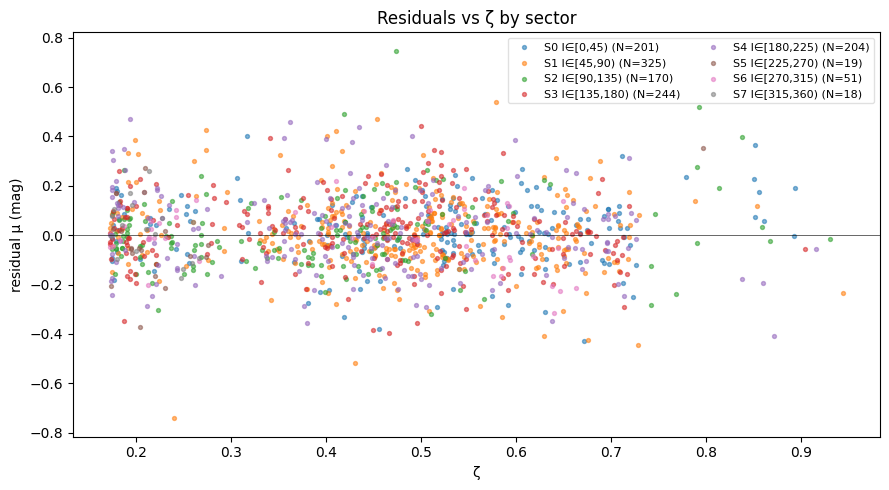

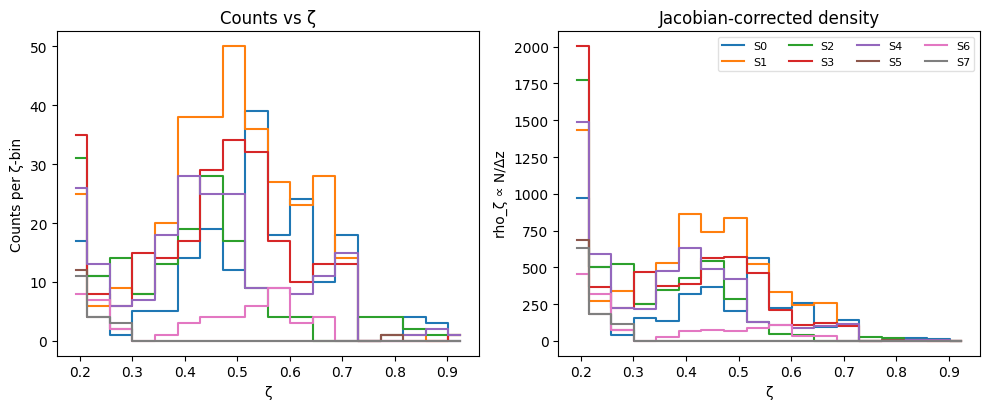

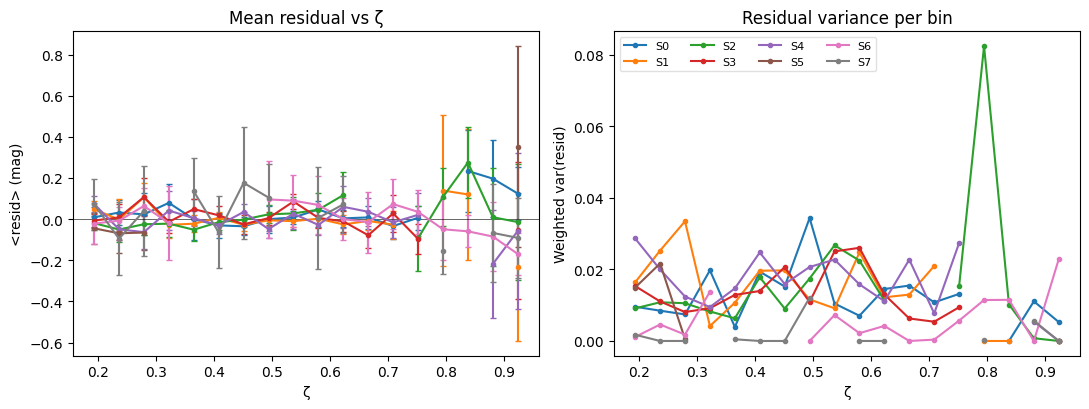

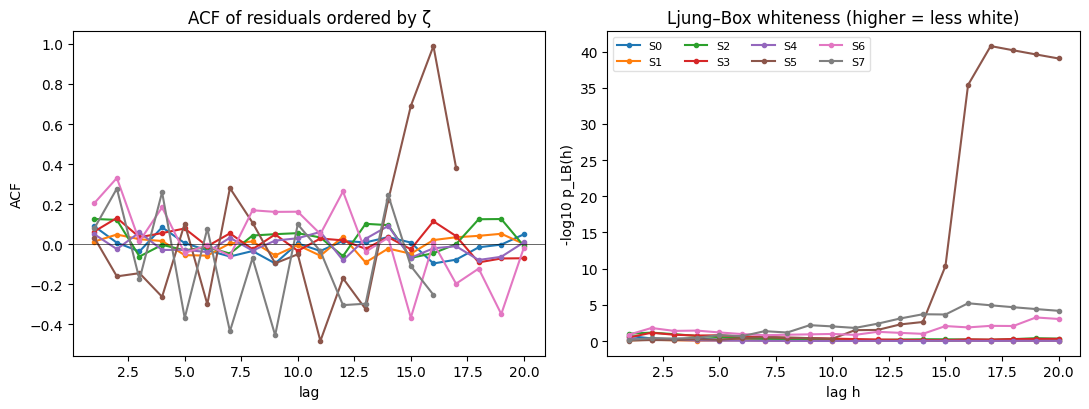

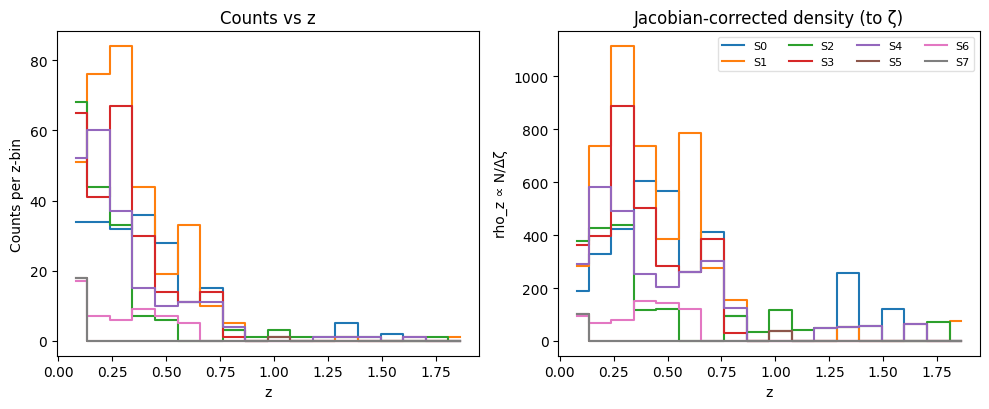

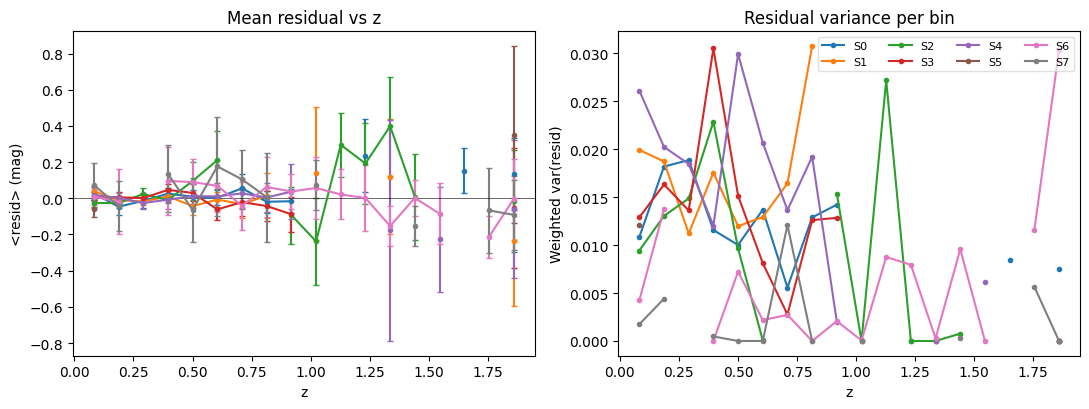

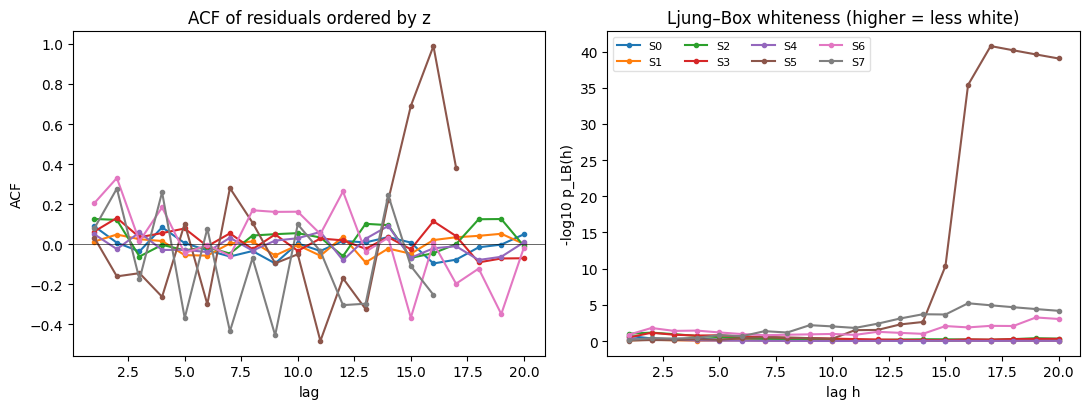

In [105]:
# unimetry_sectors_8.py
# 8 sky sectors; overlay diagnostics per sector (ζ and z)
import numpy as np, pandas as pd, matplotlib.pyplot as plt, argparse, warnings
from pathlib import Path

# ---------- Config (defaults can be overridden by CLI) ----------
DATA_PATH = Path("./Pantheon+SH0ES.dat")
H0        = 70.0
OMEGA_K   = 0.0
OM_GRID   = np.linspace(0.05, 0.6, 241)
Z_MIN, Z_MAX = 0.03, 2.0
PEC_Z_CLIP   = 0.003
ADD_PEC_ERR  = True
SIGMA_FLOOR  = 0.12
NSECT        = 8
COLORS       = plt.rcParams['axes.prop_cycle'].by_key().get('color', ['C0','C1','C2','C3','C4','C5','C6','C7'])

c_km_s = 299792.458
warnings.simplefilter("ignore", category=DeprecationWarning)

# ---------- Helpers ----------
def _read_any(path: Path) -> pd.DataFrame:
    try:
        df = pd.read_table(path, comment='#', sep=r"\s+", engine="python")
        if len(df.columns) == 1:
            df = pd.read_csv(path, comment='#')
        return df
    except Exception:
        try:
            return pd.read_csv(path, comment='#')
        except Exception:
            return pd.read_csv(path, delim_whitespace=True, comment='#')

def load_sn_table(path: Path, prefer="zhd") -> pd.DataFrame:
    if not path.exists(): raise FileNotFoundError(path)
    df = _read_any(path)
    if len(df.columns)==1:
        df = pd.read_table(path, comment='#', sep=r"\s+", engine="python")

    cols = {c.lower().strip(): c for c in df.columns}
    def pick(*names):
        for n in names:
            k=n.lower()
            if k in cols: return cols[k]
        return None

    if prefer.lower()=="zhd":
        zcol = pick("zhd","zcmb","z")
    else:
        zcol = pick("zcmb","zhd","z")
    mucol  = pick("mu","mu_sh0es","distmod","m_b_corr","m_b","mb")
    sigcol = pick("mu_err","sigma_mu","mu_sh0es_err_diag","m_b_corr_err_diag","dmu","merr","dmb")
    vperr  = pick("vpecerr","vpec_err","sigma_vpec")
    racol  = pick("ra","alpha","ra_deg")
    decol  = pick("dec","decl","dec_deg")

    if zcol is None or mucol is None or racol is None or decol is None:
        raise ValueError(f"Need z, mu, RA, DEC. Have: {list(df.columns)}")

    out = pd.DataFrame()
    out["z"]        = df[zcol].astype(float)
    out["mu_like"]  = df[mucol].astype(float)
    out["RA"]       = df[racol].astype(float)  # deg
    out["DEC"]      = df[decol].astype(float)  # deg

    if sigcol is not None:
        out["sigma_mu"] = df[sigcol].astype(float).clip(lower=SIGMA_FLOOR)
    else:
        out["sigma_mu"] = SIGMA_FLOOR

    if ADD_PEC_ERR and (vperr is not None):
        zv = np.clip(out["z"].values, PEC_Z_CLIP, None)
        sigma_v = df[vperr].astype(float).values
        sigma_mu_pec = (5.0/np.log(10.0)) * (sigma_v / (c_km_s * zv))
        out["sigma_mu"] = np.sqrt(out["sigma_mu"].values**2 + sigma_mu_pec**2)

    out = out.replace([np.inf,-np.inf], np.nan).dropna(subset=["z","mu_like","sigma_mu","RA","DEC"])
    out = out[(out["z"]>=Z_MIN) & (out["z"]<=Z_MAX)].reset_index(drop=True)
    return out

# --- Cosmology ---
def E_z(z, Om, Ok, Ol): z=np.asarray(z,float); return np.sqrt(Om*(1+z)**3 + Ok*(1+z)**2 + Ol)
def DC_dimless(z, Om, Ok, Ol, Nint=800):
    z=float(z); 
    if z<=0: return 0.0
    zg = np.linspace(0.0, z, Nint)
    Ez = E_z(zg, Om, Ok, Ol)
    return np.trapz(1.0/np.maximum(Ez,1e-12), zg)
def S_k(x, Ok):
    if np.isclose(Ok,0.0): return x
    s=np.sqrt(abs(Ok))
    return np.sinh(s*x)/s if Ok>0 else np.sin(s*x)/s
def mu_theory(z, Om, Ok, Ol, M0, H0=H0):
    z = np.atleast_1d(z)
    DC = np.array([DC_dimless(zi, Om, Ok, Ol) for zi in z])
    DM = np.array([S_k(d, Ok) for d in DC])
    DL = (c_km_s/H0) * (1.0+z) * DM
    mu = 5.0*np.log10(np.clip(DL,1e-9,None)) + 25.0 + M0
    return mu if mu.size>1 else float(mu)

def fit_lcdm(sn):
    z = sn["z"].values; y = sn["mu_like"].values; w = 1.0/sn["sigma_mu"].values**2
    best=None
    for Om in OM_GRID:
        Ok = OMEGA_K; Ol = 1.0-Om-Ok
        mu0 = mu_theory(z, Om, Ok, Ol, M0=0.0)
        M   = np.sum(w*(y-mu0))/np.sum(w)
        r   = y - (mu0 + M)
        chi2= np.sum(w*r*r)
        if (best is None) or (chi2<best["chi2"]):
            best=dict(Om=float(Om), Ok=float(Ok), Ol=float(Ol), M=float(M),
                      chi2=float(chi2), resid=r, mu0=mu0)
    N=len(z); k=2
    best["dof"]=int(N-k); best["chi2_red"]=best["chi2"]/max(1,best["dof"])
    return best

# --- ζ & Jacobians ---
def z_to_zeta(z): z=np.asarray(z,float); return np.arctan(np.sqrt(np.clip(z,0,None)))
def jac_z_to_zeta(z): 
    # dζ/dz = 1/[2 sqrt{z}(1+z)]  for z>0; we will need Δζ from bin edges
    z=np.asarray(z,float); return 1.0/(2.0*np.sqrt(np.clip(z,1e-12,None))*(1.0+z))

# --- Sky sectors ---
# Robust RA/DEC [deg] -> Galactic (l,b) [deg] using IAU 1958/J2000 constants
RA_NGP  = np.deg2rad(192.85948)
DEC_NGP = np.deg2rad(27.12825)
L_CP    = np.deg2rad(122.932)  # l at RA=0,Dec=0 along the great circle (or use 32.93192 for l_omega; both are consistent with formula below)

def radec_to_gal(ra_deg, dec_deg):
    ra = np.deg2rad(ra_deg); dec = np.deg2rad(dec_deg)
    b  = np.arcsin( np.sin(dec)*np.sin(DEC_NGP) + np.cos(dec)*np.cos(DEC_NGP)*np.cos(ra-RA_NGP) )
    y  = np.cos(dec)*np.sin(ra-RA_NGP)
    x  = np.sin(dec)*np.cos(DEC_NGP) - np.cos(dec)*np.sin(DEC_NGP)*np.cos(ra-RA_NGP)
    l  = np.arctan2(y, x) + L_CP  # wrap to [0,2π)
    l  = (l + 2*np.pi) % (2*np.pi)
    return np.rad2deg(l), np.rad2deg(b)

def assign_sectors(sn, frame="gal", nsect=8):
    if frame=="gal":
        l,b = radec_to_gal(sn["RA"].values, sn["DEC"].values)
        phi = l % 360.0
        label_prefix = "l"
    else:
        phi = sn["RA"].values % 360.0
        label_prefix = "RA"
    width = 360.0/nsect
    sec = np.floor(phi/width).astype(int)
    sec = np.clip(sec, 0, nsect-1)
    edges = [(i*width, (i+1)*width) for i in range(nsect)]
    labels = [f"S{i} {label_prefix}∈[{a:.0f},{b:.0f})" for i,(a,b) in enumerate(edges)]
    return sec, labels, edges

# --- Binning/stats for overlays ---
def binned_stats_equal_x(x, resid, sigma, nbins):
    x = np.asarray(x); resid=np.asarray(resid); sigma=np.asarray(sigma)
    w = 1.0/np.maximum(sigma,1e-9)**2
    xmin, xmax = np.nanmin(x), np.nanmax(x)
    edges = np.linspace(xmin, xmax, nbins+1)
    centers = 0.5*(edges[:-1]+edges[1:])
    N = np.zeros(nbins, int); mean = np.full(nbins, np.nan); se=np.full(nbins, np.nan); varw=np.full(nbins, np.nan)
    for j in range(nbins):
        m = (x>=edges[j]) & (x<(edges[j+1] if j<nbins-1 else edges[j+1]+1e-9))
        N[j]=int(m.sum())
        if N[j]>0:
            wj=w[m]; rj=resid[m]
            W = np.sum(wj)
            mu = np.sum(wj*rj)/W
            mean[j]=mu
            se[j]=np.sqrt(1.0/np.maximum(W,1e-12))
            varw[j]=np.sum(wj*(rj-mu)**2)/W
    return dict(edges=edges, centers=centers, N=N, mean=mean, se=se, varw=varw)

def weighted_linreg(x, y, w):
    x=np.asarray(x,float); y=np.asarray(y,float); w=np.asarray(w,float)
    m = np.isfinite(x)&np.isfinite(y)&np.isfinite(w)&(w>0)
    x,y,w = x[m],y[m],w[m]
    if len(x)<3: return np.nan,np.nan,np.nan,np.nan,np.nan
    W=np.sum(w); xbar=np.sum(w*x)/W; ybar=np.sum(w*y)/W
    Sxx=np.sum(w*(x-xbar)**2); Sxy=np.sum(w*(x-xbar)*(y-ybar))
    b=Sxy/np.maximum(Sxx,1e-30); a=ybar-b*xbar
    r=y-(a+b*x); s2=np.sum(w*r*r)/W; sb=np.sqrt(s2/np.maximum(Sxx,1e-30))
    from math import erf, sqrt
    t=b/np.maximum(sb,1e-30); p=2*(1-0.5*(1+erf(abs(t)/sqrt(2))))
    return a,b,sb,t,p

def acf_series(x, nlags=20):
    x=np.asarray(x,float); x=x-np.nanmean(x); n=len(x)
    if n<2: return np.full(nlags,np.nan)
    var=np.nanvar(x); ac=[]
    for k in range(1,nlags+1):
        if n-k<=1 or var<=0: ac.append(np.nan)
        else: ac.append(np.nansum(x[:n-k]*x[k:])/((n-k)*var))
    return np.array(ac)

def ljung_box_Q(ac, n):
    h=np.arange(1,len(ac)+1)
    with np.errstate(divide='ignore', invalid='ignore'):
        Q = n*(n+2)*np.cumsum(np.nan_to_num(ac)**2/np.maximum(n-h,1))
    return Q

def chi2_sf(x, k):
    try:
        import scipy.stats as st
        return st.chi2.sf(float(x), int(k))
    except Exception:
        # simple Wilson-Hilferty approx
        from math import sqrt
        z = ((x/k)**(1/3) - (1 - 2/(9*k))) / sqrt(2/(9*k))
        # two-sided tail for normal
        from math import erf
        return 1 - 0.5*(1+erf(z/np.sqrt(2)))

# ---------- Plots ----------
def scatter_resid_vs_zeta(sn, resid, sectors, labels, out="scatter_resid_vs_zeta_by_sector.png"):
    zeta = z_to_zeta(sn["z"].values)
    plt.figure(figsize=(9,5))
    for s in range(NSECT):
        m = (sectors==s)
        if m.sum()==0: continue
        plt.scatter(zeta[m], resid[m], s=8, alpha=0.55, label=f"{labels[s]} (N={m.sum()})", color=COLORS[s % len(COLORS)])
    plt.axhline(0, lw=0.7, color="k", alpha=0.6)
    plt.xlabel("ζ"); plt.ylabel("residual μ (mag)")
    plt.title("Residuals vs ζ by sector")
    plt.legend(ncol=2, fontsize=8, framealpha=0.6)
    plt.tight_layout(); plt.savefig(out, dpi=160)

def overlay_density_zeta(sn, sectors, out="zeta_density_by_sector.png", nbins=18):
    z = sn["z"].values; zeta=z_to_zeta(z)
    z_edges = np.linspace(np.nanmin(z), np.nanmax(z), nbins+1)
    zeta_edges = np.linspace(np.nanmin(zeta), np.nanmax(zeta), nbins+1)
    zeta_cent = 0.5*(zeta_edges[:-1]+zeta_edges[1:])
    plt.figure(figsize=(10,4.2))
    # left: counts per ζ-bin
    ax1 = plt.subplot(1,2,1)
    for s in range(NSECT):
        m = (sectors==s); 
        if m.sum()==0: continue
        hist,_ = np.histogram(zeta[m], bins=zeta_edges)
        ax1.step(zeta_cent, hist, where='mid', label=f"S{s}", color=COLORS[s%len(COLORS)])
    ax1.set_xlabel("ζ"); ax1.set_ylabel("Counts per ζ-bin"); ax1.set_title("Counts vs ζ")
    # right: rho_hat(ζ) ∝ N/Δz
    ax2 = plt.subplot(1,2,2)
    dz = np.diff(np.interp(zeta_edges, zeta, z, left=np.nanmin(z), right=np.nanmax(z)))
    for s in range(NSECT):
        m = (sectors==s); 
        if m.sum()==0: continue
        hist,_ = np.histogram(zeta[m], bins=zeta_edges)
        rho = np.where(dz>0, hist/np.maximum(dz,1e-12), np.nan)
        ax2.step(zeta_cent, rho, where='mid', label=f"S{s}", color=COLORS[s%len(COLORS)])
    ax2.set_xlabel("ζ"); ax2.set_ylabel("rho_ζ ∝ N/Δz"); ax2.set_title("Jacobian-corrected density")
    plt.legend(ncol=4, fontsize=8, framealpha=0.6)
    plt.tight_layout(); plt.savefig(out, dpi=160)

def overlay_meanvar(sn, resid, sectors, xname="zeta", nbins=18, out="zeta_meanvar_by_sector.png"):
    x = z_to_zeta(sn["z"].values) if xname=="zeta" else sn["z"].values
    sigma = sn["sigma_mu"].values
    edges = np.linspace(np.nanmin(x), np.nanmax(x), nbins+1)
    centers = 0.5*(edges[:-1]+edges[1:])
    fig, ax = plt.subplots(1,2, figsize=(11,4.2))
    # left: <resid>(x) with fits
    for s in range(NSECT):
        m = (sectors==s)
        if m.sum()==0: continue
        bs = binned_stats_equal_x(x[m], resid[m], sigma[m], nbins)
        ax[0].errorbar(centers, bs["mean"], yerr=bs["se"], fmt='o-', ms=3, capsize=2, color=COLORS[s%len(COLORS)], label=f"S{s}")
    ax[0].axhline(0, color="k", lw=0.7, alpha=0.6)
    ax[0].set_xlabel("ζ" if xname=="zeta" else "z"); ax[0].set_ylabel("<resid> (mag)")
    ax[0].set_title(f"Mean residual vs {'ζ' if xname=='zeta' else 'z'}")
    # right: var_w per bin
    for s in range(NSECT):
        m = (sectors==s)
        if m.sum()==0: continue
        bs = binned_stats_equal_x(x[m], resid[m], sigma[m], nbins)
        ax[1].plot(centers, bs["varw"], 'o-', ms=3, color=COLORS[s%len(COLORS)], label=f"S{s}")
    ax[1].set_xlabel("ζ" if xname=="zeta" else "z"); ax[1].set_ylabel("Weighted var(resid)")
    ax[1].set_title("Residual variance per bin")
    ax[1].legend(ncol=4, fontsize=8, framealpha=0.6, loc="best")
    fig.tight_layout(); fig.savefig(out, dpi=160)

def overlay_acf(sn, resid, sectors, xname="zeta", nlags=20, out="zeta_acf_ljungbox_by_sector.png"):
    x = z_to_zeta(sn["z"].values) if xname=="zeta" else sn["z"].values
    fig, ax = plt.subplots(1,2, figsize=(11,4.2))
    # left: ACF lines
    for s in range(NSECT):
        m = (sectors==s)
        if m.sum()<10: continue
        idx = np.argsort(x[m])
        r = resid[m][idx]
        ac = acf_series(r, nlags=nlags)
        ax[0].plot(np.arange(1,nlags+1), ac, 'o-', ms=3, color=COLORS[s%len(COLORS)], label=f"S{s}")
    ax[0].axhline(0, color='k', lw=0.7, alpha=0.6); ax[0].set_xlabel("lag"); ax[0].set_ylabel("ACF")
    ax[0].set_title(f"ACF of residuals ordered by {'ζ' if xname=='zeta' else 'z'}")
    # right: Ljung–Box
    for s in range(NSECT):
        m = (sectors==s)
        if m.sum()<10: continue
        idx = np.argsort(x[m]); r = resid[m][idx]; n=len(r)
        ac = acf_series(r, nlags=nlags); Q = ljung_box_Q(ac, n)
        pvals = [chi2_sf(Q[k-1], k) for k in range(1, nlags+1)]
        y = np.array([(-np.log10(p) if (p is not None and p>0) else np.nan) for p in pvals])
        ax[1].plot(np.arange(1, nlags+1), y, 'o-', ms=3, color=COLORS[s%len(COLORS)], label=f"S{s}")
    ax[1].set_xlabel("lag h"); ax[1].set_ylabel("-log10 p_LB(h)")
    ax[1].set_title("Ljung–Box whiteness (higher = less white)")
    ax[1].legend(ncol=4, fontsize=8, framealpha=0.6, loc="best")
    fig.tight_layout(); fig.savefig(out, dpi=160)

def overlay_density_z(sn, sectors, out="z_density_by_sector.png", nbins=18):
    z = sn["z"].values
    z_edges = np.linspace(np.nanmin(z), np.nanmax(z), nbins+1)
    z_cent  = 0.5*(z_edges[:-1]+z_edges[1:])
    plt.figure(figsize=(10,4.2))
    ax1 = plt.subplot(1,2,1)
    for s in range(NSECT):
        m=(sectors==s)
        if m.sum()==0: continue
        hist,_ = np.histogram(z[m], bins=z_edges)
        ax1.step(z_cent, hist, where='mid', label=f"S{s}", color=COLORS[s%len(COLORS)])
    ax1.set_xlabel("z"); ax1.set_ylabel("Counts per z-bin"); ax1.set_title("Counts vs z")
    ax2 = plt.subplot(1,2,2)
    # Δζ from edges
    zeta_edges = z_to_zeta(z_edges)
    dze = np.diff(zeta_edges)
    for s in range(NSECT):
        m=(sectors==s)
        if m.sum()==0: continue
        hist,_ = np.histogram(z[m], bins=z_edges)
        rho = np.where(dze>0, hist/np.maximum(dze,1e-12), np.nan)
        ax2.step(z_cent, rho, where='mid', label=f"S{s}", color=COLORS[s%len(COLORS)])
    ax2.set_xlabel("z"); ax2.set_ylabel("rho_z ∝ N/Δζ"); ax2.set_title("Jacobian-corrected density (to ζ)")
    plt.legend(ncol=4, fontsize=8, framealpha=0.6)
    plt.tight_layout(); plt.savefig(out, dpi=160)

# ---------- Main ----------
def main():
    ap = argparse.ArgumentParser(description="Sector overlays for SN residual diagnostics")
    ap.add_argument("--data", type=str, default=str(DATA_PATH))
    ap.add_argument("--prefer", type=str, default="zhd", choices=["zhd","zcmb"])
    ap.add_argument("--frame",  type=str, default="gal", choices=["gal","equ"])
    ap.add_argument("--nbins",  type=int, default=18)
    args, _ = ap.parse_known_args()

    sn = load_sn_table(Path(args.data), prefer=args.prefer)
    lcdm = fit_lcdm(sn)
    mu0 = mu_theory(sn["z"].values, lcdm["Om"], lcdm["Ok"], lcdm["Ol"], M0=lcdm["M"])
    resid = sn["mu_like"].values - mu0

    sectors, labels, edges = assign_sectors(sn, frame=args.frame, nsect=NSECT)

    # 0) Scatter resid vs ζ
    scatter_resid_vs_zeta(sn, resid, sectors, labels)

    # 1) ζ: density overlays
    overlay_density_zeta(sn, sectors, nbins=args.nbins)

    # 2) ζ: mean/var overlays
    overlay_meanvar(sn, resid, sectors, xname="zeta", nbins=args.nbins)

    # 3) ζ: ACF/LB overlays
    overlay_acf(sn, resid, sectors, xname="zeta", nlags=20)

    # 4) z: density overlays
    overlay_density_z(sn, sectors, nbins=args.nbins)

    # 5) z: mean/var overlays
    overlay_meanvar(sn, resid, sectors, xname="z", nbins=args.nbins, out="z_meanvar_by_sector.png")

    # 6) z: ACF/LB overlays
    overlay_acf(sn, resid, sectors, xname="z", nlags=20, out="z_acf_ljungbox_by_sector.png")

    # Stats table per sector (for лог)
    rows=[]
    zeta = z_to_zeta(sn["z"].values); w = 1.0/sn["sigma_mu"].values**2
    for s in range(NSECT):
        m=(sectors==s); N=int(m.sum())
        if N<5:
            rows.append(dict(sector=s, N=N, b_zeta=np.nan, sb_zeta=np.nan, p_zeta=np.nan, b_z=np.nan, sb_z=np.nan, p_z=np.nan))
            continue
        a,b,sb,t,p = weighted_linreg(zeta[m], resid[m], w[m]); 
        a2,b2,sb2,t2,p2 = weighted_linreg(sn["z"].values[m], resid[m], w[m])
        rows.append(dict(sector=s, N=N, b_zeta=b, sb_zeta=sb, p_zeta=p, b_z=b2, sb_z=sb2, p_z=p2))
    pd.DataFrame(rows).to_csv("sector_stats.csv", index=False)

    print("Saved images:")
    for f in ["scatter_resid_vs_zeta_by_sector.png",
              "zeta_density_by_sector.png",
              "zeta_meanvar_by_sector.png",
              "zeta_acf_ljungbox_by_sector.png",
              "z_density_by_sector.png",
              "z_meanvar_by_sector.png",
              "z_acf_ljungbox_by_sector.png"]:
        print(" -", f)
    print("And summary: sector_stats.csv")
    print(f"Baseline fit: Ωm={lcdm['Om']:.3f}, ΩΛ={lcdm['Ol']:.3f}, M={lcdm['M']:+.3f}, χ²_red={lcdm['chi2_red']:.3f}")

if __name__=="__main__":
    main()


In [1]:
# unimetry_octant_scan.py
# Scan 8 sky octants; diagnostics per octant (ζ and z) + overlays

import numpy as np, pandas as pd, matplotlib.pyplot as plt, argparse, warnings, os
from pathlib import Path

# --------- Defaults ----------
DATA_PATH   = Path("./Pantheon+SH0ES.dat")
PREFER      = "zhd"       # or "zcmb"
FRAME       = "gal"       # 'gal' (galactic l) or 'equ' (RA)
NBINS       = 14          # per-axis bins (per octant); overlays используют те же центры
NLAGS       = 20
Z_RANGE     = (0.03, 2.0)
H0          = 70.0
OMEGA_K     = 0.0
OM_GRID     = np.linspace(0.05, 0.6, 241)
ADD_PEC_ERR = True
PEC_Z_CLIP  = 0.003
SIGMA_FLOOR = 0.12
OUTDIR      = "octant_scan_out"

c_km_s = 299792.458
warnings.simplefilter("ignore", category=DeprecationWarning)

# --------- IO helpers ----------
def _read_any(path: Path) -> pd.DataFrame:
    try:
        df = pd.read_table(path, comment="#", sep=r"\s+", engine="python")
        if len(df.columns)==1:
            df = pd.read_csv(path, comment="#")
        return df
    except Exception:
        try:
            return pd.read_csv(path, comment="#")
        except Exception:
            return pd.read_csv(path, delim_whitespace=True, comment="#")

def load_sn_table(path: Path, prefer="zhd"):
    if not path.exists(): raise FileNotFoundError(path)
    df = _read_any(path)
    if len(df.columns)==1:
        df = pd.read_table(path, comment="#", sep=r"\s+", engine="python")
    cols = {c.lower().strip(): c for c in df.columns}
    def pick(*names):
        for n in names:
            k=n.lower()
            if k in cols: return cols[k]
        return None
    zcol   = pick("zhd","zcmb","z") if prefer.lower()=="zhd" else pick("zcmb","zhd","z")
    mucol  = pick("mu","mu_sh0es","distmod","m_b_corr","m_b","mb")
    sigcol = pick("mu_err","sigma_mu","mu_sh0es_err_diag","m_b_corr_err_diag","dmu","dmb","merr")
    vperr  = pick("vpecerr","vpec_err","sigma_vpec")
    racol  = pick("ra","alpha","ra_deg")
    decol  = pick("dec","decl","dec_deg")
    if zcol is None or mucol is None or racol is None or decol is None:
        raise ValueError(f"Need z, mu, RA, DEC. Have: {list(df.columns)}")

    out = pd.DataFrame()
    out["z"]       = df[zcol].astype(float)
    out["mu_like"] = df[mucol].astype(float)
    out["RA"]      = df[racol].astype(float)
    out["DEC"]     = df[decol].astype(float)

    if sigcol is not None:
        out["sigma_mu"] = df[sigcol].astype(float).clip(lower=SIGMA_FLOOR)
    else:
        out["sigma_mu"] = SIGMA_FLOOR

    if ADD_PEC_ERR and (vperr is not None):
        zv = np.clip(out["z"].values, PEC_Z_CLIP, None)
        sigma_v = df[vperr].astype(float).values
        sig_pec = (5.0/np.log(10.0)) * (sigma_v / (c_km_s * zv))
        out["sigma_mu"] = np.sqrt(out["sigma_mu"].values**2 + sig_pec**2)

    zmin,zmax = Z_RANGE
    out = out.replace([np.inf,-np.inf], np.nan).dropna(subset=["z","mu_like","sigma_mu","RA","DEC"])
    out = out[(out["z"]>=zmin) & (out["z"]<=zmax)].reset_index(drop=True)
    print(f"Loaded {len(out)} SNe; z in [{zmin},{zmax}]")
    return out

# --------- Cosmology ----------
def E_z(z, Om, Ok, Ol): z=np.asarray(z,float); return np.sqrt(Om*(1+z)**3 + Ok*(1+z)**2 + Ol)
def DC_dimless(z, Om, Ok, Ol, Nint=800):
    z=float(z)
    if z<=0: return 0.0
    zg = np.linspace(0.0, z, Nint); Ez=E_z(zg,Om,Ok,Ol)
    return np.trapz(1.0/np.maximum(Ez,1e-12), zg)
def S_k(x, Ok):
    if np.isclose(Ok,0.0): return x
    s=np.sqrt(abs(Ok))
    return np.sinh(s*x)/s if Ok>0 else np.sin(s*x)/s
def mu_theory(z, Om, Ok, Ol, M0):
    z = np.atleast_1d(z)
    DC = np.array([DC_dimless(zi, Om, Ok, Ol) for zi in z])
    DM = np.array([S_k(d, Ok) for d in DC])
    DL = (c_km_s/H0)*(1.0+z)*DM
    mu = 5*np.log10(np.clip(DL,1e-9,None)) + 25 + M0
    return mu if mu.size>1 else float(mu)
def fit_lcdm(sn):
    z=sn["z"].values; y=sn["mu_like"].values; w=1.0/sn["sigma_mu"].values**2
    best=None
    for Om in OM_GRID:
        Ok=OMEGA_K; Ol=1-Om-Ok
        mu0 = mu_theory(z, Om, Ok, Ol, M0=0.0)
        M   = np.sum(w*(y-mu0))/np.sum(w)
        r   = y-(mu0+M)
        chi2= np.sum(w*r*r)
        if (best is None) or (chi2<best["chi2"]):
            best=dict(Om=float(Om),Ok=float(Ok),Ol=float(Ol),M=float(M),chi2=float(chi2),resid=r,mu0=mu0)
    N=len(z); k=2
    best["dof"]=int(N-k); best["chi2_red"]=best["chi2"]/max(1,best["dof"])
    return best

# --------- ζ, линейка и статистика ----------
def z_to_zeta(z): z=np.asarray(z,float); return np.arctan(np.sqrt(np.clip(z,0,None)))
def binned_stats_equal_x(x, resid, sigma, nbins):
    x=np.asarray(x); r=np.asarray(resid); s=np.asarray(sigma)
    w = 1.0/np.maximum(s,1e-12)**2
    edges = np.linspace(np.nanmin(x), np.nanmax(x), nbins+1)
    centers = 0.5*(edges[:-1]+edges[1:])
    N=np.zeros(nbins,int); mean=np.full(nbins,np.nan); se=np.full(nbins,np.nan); varw=np.full(nbins,np.nan)
    for j in range(nbins):
        m=(x>=edges[j]) & (x<(edges[j+1] if j<nbins-1 else edges[j+1]+1e-12))
        N[j]=int(m.sum())
        if N[j]>0:
            wj=w[m]; rj=r[m]; W=np.sum(wj)
            mu=np.sum(wj*rj)/W
            mean[j]=mu; se[j]=np.sqrt(1.0/np.maximum(W,1e-12))
            varw[j]=np.sum(wj*(rj-mu)**2)/W
    return dict(edges=edges, centers=centers, N=N, mean=mean, se=se, varw=varw)
def weighted_linreg(x,y,w):
    x=np.asarray(x,float); y=np.asarray(y,float); w=np.asarray(w,float)
    m=np.isfinite(x)&np.isfinite(y)&np.isfinite(w)&(w>0); x,y,w=x[m],y[m],w[m]
    if len(x)<3: return np.nan,np.nan,np.nan,np.nan,np.nan
    W=np.sum(w); xb=np.sum(w*x)/W; yb=np.sum(w*y)/W
    Sxx=np.sum(w*(x-xb)**2); Sxy=np.sum(w*(x-xb)*(y-yb)); b=Sxy/np.maximum(Sxx,1e-30); a=yb-b*xb
    r=y-(a+b*x); s2=np.sum(w*r*r)/W; sb=np.sqrt(s2/np.maximum(Sxx,1e-30))
    from math import erf, sqrt
    t=b/np.maximum(sb,1e-30); p=2*(1-0.5*(1+erf(abs(t)/sqrt(2))))
    return a,b,sb,t,p
def acf_series(x, nlags=20):
    x=np.asarray(x,float); x=x-np.nanmean(x); n=len(x)
    if n<2: return np.full(nlags,np.nan)
    var=np.nanvar(x); ac=[]
    for k in range(1,nlags+1):
        if n-k<=1 or var<=0: ac.append(np.nan)
        else: ac.append(np.nansum(x[:n-k]*x[k:])/((n-k)*var))
    return np.array(ac)
def ljung_box_Q(ac, n):
    h=np.arange(1,len(ac)+1)
    with np.errstate(divide='ignore', invalid='ignore'):
        return n*(n+2)*np.cumsum(np.nan_to_num(ac)**2/np.maximum(n-h,1))
def chi2_sf(x,k):
    try:
        import scipy.stats as st
        return st.chi2.sf(float(x), int(k))
    except Exception:
        # Wilson–Hilferty approx
        from math import sqrt
        z = ((x/k)**(1/3) - (1 - 2/(9*k))) / sqrt(2/(9*k))
        from math import erf
        return 1 - 0.5*(1+erf(z/np.sqrt(2)))

# --------- RA/DEC -> Galactic ----------
RA_NGP  = np.deg2rad(192.85948)
DEC_NGP = np.deg2rad(27.12825)
L_CP    = np.deg2rad(122.932)
def radec_to_gal(ra_deg, dec_deg):
    ra=np.deg2rad(ra_deg); dec=np.deg2rad(dec_deg)
    b  = np.arcsin(np.sin(dec)*np.sin(DEC_NGP)+np.cos(dec)*np.cos(DEC_NGP)*np.cos(ra-RA_NGP))
    y  = np.cos(dec)*np.sin(ra-RA_NGP)
    x  = np.sin(dec)*np.cos(DEC_NGP)-np.cos(dec)*np.sin(DEC_NGP)*np.cos(ra-RA_NGP)
    l  = (np.arctan2(y,x)+L_CP)%(2*np.pi)
    return np.rad2deg(l), np.rad2deg(b)

# --------- Octants ----------
def assign_octants(sn, frame="gal"):
    if frame=="gal":
        l,_ = radec_to_gal(sn["RA"].values, sn["DEC"].values)
        phi = l % 360.0; prefix="l"
    else:
        phi = sn["RA"].values % 360.0; prefix="RA"
    width = 45.0
    oct_idx = np.floor(phi/width).astype(int)
    oct_idx = np.clip(oct_idx, 0, 7)
    edges = [(i*width, (i+1)*width) for i in range(8)]
    labels=[f"O{i} {prefix}∈[{a:.0f},{b:.0f})" for i,(a,b) in enumerate(edges)]
    return oct_idx, labels, edges

# --------- Plots ----------
def ensure_outdir(path):
    Path(path).mkdir(parents=True, exist_ok=True)
    return Path(path)

def scatter_by_octant(sn, resid, oct_idx, labels, outdir):
    zeta = z_to_zeta(sn["z"].values)
    # общий
    cmap = plt.rcParams['axes.prop_cycle'].by_key().get('color', [f"C{i}" for i in range(10)])
    plt.figure(figsize=(9,5))
    for s in range(8):
        m=(oct_idx==s)
        if m.sum()==0: continue
        plt.scatter(zeta[m], resid[m], s=8, alpha=0.55, label=f"{labels[s]} (N={m.sum()})", color=cmap[s%len(cmap)])
    plt.axhline(0, color="k", lw=0.7, alpha=0.6)
    plt.xlabel("ζ"); plt.ylabel("residual μ (mag)"); plt.title("Residuals vs ζ by octant")
    plt.legend(ncol=2, fontsize=8, framealpha=0.6); plt.tight_layout()
    plt.savefig(outdir/"scatter_resid_vs_zeta_all_octants.png", dpi=160); plt.close()
    # по-отдельности
    for s in range(8):
        m=(oct_idx==s)
        if m.sum()==0: continue
        plt.figure(figsize=(7,4.5))
        plt.scatter(zeta[m], resid[m], s=10, alpha=0.7, color=cmap[s%len(cmap)])
        plt.axhline(0, color="k", lw=0.7, alpha=0.6)
        plt.xlabel("ζ"); plt.ylabel("residual μ (mag)")
        plt.title(f"Residuals vs ζ — {labels[s]} (N={m.sum()})")
        plt.tight_layout(); plt.savefig(outdir/f"scatter_resid_vs_zeta_oct{s}.png", dpi=160); plt.close()

def overlay_meanvar(sn, resid, oct_idx, coord="zeta", nbins=NBINS, outpath=None):
    x = z_to_zeta(sn["z"].values) if coord=="zeta" else sn["z"].values
    sigma = sn["sigma_mu"].values
    edges = np.linspace(np.nanmin(x), np.nanmax(x), nbins+1)
    centers=0.5*(edges[:-1]+edges[1:])
    cmap = plt.rcParams['axes.prop_cycle'].by_key().get('color', [f"C{i}" for i in range(10)])
    fig,ax = plt.subplots(1,2, figsize=(11,4.2))
    for s in range(8):
        m=(oct_idx==s); 
        if m.sum()==0: continue
        bs=binned_stats_equal_x(x[m], resid[m], sigma[m], nbins)
        ax[0].errorbar(centers, bs["mean"], yerr=bs["se"], fmt='o-', ms=3, capsize=2, color=cmap[s%len(cmap)], label=f"O{s}")
        ax[1].plot(centers, bs["varw"], 'o-', ms=3, color=cmap[s%len(cmap)], label=f"O{s}")
    ax[0].axhline(0, color="k", lw=0.7, alpha=0.6)
    ax[0].set_xlabel("ζ" if coord=="zeta" else "z"); ax[0].set_ylabel("<resid> (mag)")
    ax[0].set_title(f"Mean residual vs {'ζ' if coord=='zeta' else 'z'} — octants")
    ax[1].set_xlabel("ζ" if coord=="zeta" else "z"); ax[1].set_ylabel("Weighted var(resid)")
    ax[1].set_title("Residual variance per bin")
    ax[1].legend(ncol=4, fontsize=8, framealpha=0.6, loc="best")
    fig.tight_layout()
    if outpath: fig.savefig(outpath, dpi=160)
    plt.close(fig)

def overlay_acf(sn, resid, oct_idx, coord="zeta", nlags=NLAGS, outpath=None):
    x = z_to_zeta(sn["z"].values) if coord=="zeta" else sn["z"].values
    cmap = plt.rcParams['axes.prop_cycle'].by_key().get('color', [f"C{i}" for i in range(10)])
    fig,ax = plt.subplots(1,2, figsize=(11,4.2))
    for s in range(8):
        m=(oct_idx==s)
        if m.sum()<10: continue
        idx=np.argsort(x[m]); r=resid[m][idx]; n=len(r)
        ac=acf_series(r, nlags=nlags); Q=ljung_box_Q(ac, n)
        ax[0].plot(np.arange(1,nlags+1), ac, 'o-', ms=3, color=cmap[s%len(cmap)], label=f"O{s}")
        pvals=[chi2_sf(Q[k-1], k) for k in range(1, nlags+1)]
        y=np.array([(-np.log10(p) if (p is not None and p>0) else np.nan) for p in pvals])
        ax[1].plot(np.arange(1,nlags+1), y, 'o-', ms=3, color=cmap[s%len(cmap)], label=f"O{s}")
    ax[0].axhline(0, color="k", lw=0.7, alpha=0.6); ax[0].set_xlabel("lag"); ax[0].set_ylabel("ACF")
    ax[0].set_title(f"ACF ordered by {'ζ' if coord=='zeta' else 'z'} — octants")
    ax[1].set_xlabel("lag h"); ax[1].set_ylabel("-log10 p_LB(h)")
    ax[1].set_title("Ljung–Box whiteness (higher = less white)")
    ax[1].legend(ncol=4, fontsize=8, framealpha=0.6, loc="best")
    fig.tight_layout()
    if outpath: fig.savefig(outpath, dpi=160)
    plt.close(fig)

def per_octant_diagnostics(sn, resid, oct_idx, labels, nbins=NBINS, nlags=NLAGS, outdir=Path(".")):
    xz = sn["z"].values; xzeta = z_to_zeta(xz); sigma = sn["sigma_mu"].values
    for s in range(8):
        m=(oct_idx==s); N=int(m.sum())
        if N<5: continue
        labsuf=f"oct{s}"
        # mean/var ζ
        bs=binned_stats_equal_x(xzeta[m], resid[m], sigma[m], nbins)
        fig,ax=plt.subplots(1,2, figsize=(10,4.2))
        ax[0].errorbar(bs["centers"], bs["mean"], yerr=bs["se"], fmt='o-'); ax[0].axhline(0, color="k", lw=0.7, alpha=0.6)
        ax[0].set_xlabel("ζ"); ax[0].set_ylabel("<resid> (mag)"); ax[0].set_title(f"{labels[s]} — mean resid vs ζ")
        ax[1].plot(bs["centers"], bs["varw"], 'o-'); ax[1].set_xlabel("ζ"); ax[1].set_ylabel("Weighted var(resid)")
        ax[1].set_title("Residual variance per ζ-bin")
        fig.tight_layout(); fig.savefig(outdir/f"zeta_meanvar_{labsuf}.png", dpi=160); plt.close(fig)
        # mean/var z
        bs=binned_stats_equal_x(xz[m], resid[m], sigma[m], nbins)
        fig,ax=plt.subplots(1,2, figsize=(10,4.2))
        ax[0].errorbar(bs["centers"], bs["mean"], yerr=bs["se"], fmt='o-'); ax[0].axhline(0, color="k", lw=0.7, alpha=0.6)
        ax[0].set_xlabel("z"); ax[0].set_ylabel("<resid> (mag)"); ax[0].set_title(f"{labels[s]} — mean resid vs z")
        ax[1].plot(bs["centers"], bs["varw"], 'o-'); ax[1].set_xlabel("z"); ax[1].set_ylabel("Weighted var(resid)")
        ax[1].set_title("Residual variance per z-bin")
        fig.tight_layout(); fig.savefig(outdir/f"z_meanvar_{labsuf}.png", dpi=160); plt.close(fig)
        # ACF/LB ζ
        fig,ax=plt.subplots(1,2, figsize=(10,4.2))
        idx=np.argsort(xzeta[m]); r=resid[m][idx]; ac=acf_series(r, nlags=nlags); n=len(r)
        ax[0].plot(np.arange(1,nlags+1), ac, 'o-'); ax[0].axhline(0, color="k", lw=0.7, alpha=0.6)
        ax[0].set_xlabel("lag"); ax[0].set_ylabel("ACF"); ax[0].set_title(f"{labels[s]} — ACF (ζ-order)")
        Q=ljung_box_Q(ac, n); p=[chi2_sf(Q[k-1],k) for k in range(1,nlags+1)]
        y=np.array([(-np.log10(pi) if (pi is not None and pi>0) else np.nan) for pi in p])
        ax[1].plot(np.arange(1,nlags+1), y, 'o-'); ax[1].set_xlabel("lag h"); ax[1].set_ylabel("-log10 p_LB(h)")
        ax[1].set_title("Ljung–Box whiteness")
        fig.tight_layout(); fig.savefig(outdir/f"zeta_acf_ljungbox_{labsuf}.png", dpi=160); plt.close(fig)
        # ACF/LB z
        fig,ax=plt.subplots(1,2, figsize=(10,4.2))
        idx=np.argsort(xz[m]); r=resid[m][idx]; ac=acf_series(r, nlags=nlags); n=len(r)
        ax[0].plot(np.arange(1,nlags+1), ac, 'o-'); ax[0].axhline(0, color="k", lw=0.7, alpha=0.6)
        ax[0].set_xlabel("lag"); ax[0].set_ylabel("ACF"); ax[0].set_title(f"{labels[s]} — ACF (z-order)")
        Q=ljung_box_Q(ac, n); p=[chi2_sf(Q[k-1],k) for k in range(1,nlags+1)]
        y=np.array([(-np.log10(pi) if (pi is not None and pi>0) else np.nan) for pi in p])
        ax[1].plot(np.arange(1,nlags+1), y, 'o-'); ax[1].set_xlabel("lag h"); ax[1].set_ylabel("-log10 p_LB(h)")
        ax[1].set_title("Ljung–Box whiteness")
        fig.tight_layout(); fig.savefig(outdir/f"z_acf_ljungbox_{labsuf}.png", dpi=160); plt.close(fig)

# --------- Main ----------
def main():
    ap = argparse.ArgumentParser(description="Octant scan for SN residuals (ζ & z)")
    ap.add_argument("--data", type=str, default=str(DATA_PATH))
    ap.add_argument("--prefer", type=str, default=PREFER, choices=["zhd","zcmb"])
    ap.add_argument("--frame",  type=str, default=FRAME,  choices=["gal","equ"])
    ap.add_argument("--nbins",  type=int, default=NBINS)
    ap.add_argument("--nlags",  type=int, default=NLAGS)
    ap.add_argument("--outdir", type=str, default=OUTDIR)
    args, _ = ap.parse_known_args()   # <— дружит с Jupyter

    outdir = ensure_outdir(args.outdir)
    sn = load_sn_table(Path(args.data), prefer=args.prefer)
    lcdm = fit_lcdm(sn)
    mu0  = mu_theory(sn["z"].values, lcdm["Om"], lcdm["Ok"], lcdm["Ol"], M0=lcdm["M"])
    resid = sn["mu_like"].values - mu0
    print(f"Baseline: Ωm={lcdm['Om']:.3f}, ΩΛ={lcdm['Ol']:.3f}, M={lcdm['M']:+.3f}, χ²_red={lcdm['chi2_red']:.3f}")

    oct_idx, labels, edges = assign_octants(sn, frame=args.frame)

    # 0) Визуализация — scatter по ζ для каждого октанта и общий
    scatter_by_octant(sn, resid, oct_idx, labels, outdir)

    # 1) Оверлеи 6 графиков (ζ и z)
    overlay_meanvar(sn, resid, oct_idx, coord="zeta", nbins=args.nbins,
                    outpath=outdir/"zeta_meanvar_by_octant.png")
    overlay_acf(sn, resid, oct_idx, coord="zeta", nlags=args.nlags,
                outpath=outdir/"zeta_acf_ljungbox_by_octant.png")
    overlay_meanvar(sn, resid, oct_idx, coord="z", nbins=args.nbins,
                    outpath=outdir/"z_meanvar_by_octant.png")
    overlay_acf(sn, resid, oct_idx, coord="z", nlags=args.nlags,
                outpath=outdir/"z_acf_ljungbox_by_octant.png")

    # 2) По-октантные картинки (ζ/z mean-var & ACF/LB)
    per_octant_diagnostics(sn, resid, oct_idx, labels, nbins=args.nbins, nlags=args.nlags, outdir=outdir)

    # 3) Таблица метрик по октантам
    zeta = z_to_zeta(sn["z"].values); w = 1.0/sn["sigma_mu"].values**2
    rows=[]
    for s in range(8):
        m=(oct_idx==s); N=int(m.sum())
        if N<5:
            rows.append(dict(octant=s, N=N, b_zeta=np.nan, sb_zeta=np.nan, p_zeta=np.nan,
                             b_z=np.nan, sb_z=np.nan, p_z=np.nan))
            continue
        a,b,sb,t,p  = weighted_linreg(zeta[m], resid[m], w[m])
        a2,b2,sb2,t2,p2 = weighted_linreg(sn["z"].values[m], resid[m], w[m])
        rows.append(dict(octant=s, N=N, b_zeta=b, sb_zeta=sb, p_zeta=p,
                         b_z=b2, sb_z=sb2, p_z=p2))
    pd.DataFrame(rows).to_csv(outdir/"octant_stats.csv", index=False)

    print("Saved to", outdir.resolve())
    for f in ["scatter_resid_vs_zeta_all_octants.png",
              "zeta_meanvar_by_octant.png", "zeta_acf_ljungbox_by_octant.png",
              "z_meanvar_by_octant.png", "z_acf_ljungbox_by_octant.png",
              "octant_stats.csv"]:
        print(" -", f)
    print("Individual-per-octant figures also saved (prefixes: scatter_resid_vs_zeta_oct*, zeta_*, z_*)")

if __name__ == "__main__":
    main()


Loaded 1232 SNe; z in [0.03,2.0]
Baseline: Ωm=0.352, ΩΛ=0.648, M=-0.089, χ²_red=0.416
Saved to C:\Projekte\_quaternions\_asperity\octant_scan_out
 - scatter_resid_vs_zeta_all_octants.png
 - zeta_meanvar_by_octant.png
 - zeta_acf_ljungbox_by_octant.png
 - z_meanvar_by_octant.png
 - z_acf_ljungbox_by_octant.png
 - octant_stats.csv
Individual-per-octant figures also saved (prefixes: scatter_resid_vs_zeta_oct*, zeta_*, z_*)


In [2]:
# unimetry_octant_scan.py
# Scan 8 sky octants; diagnostics per octant (ζ and z) + overlays

import numpy as np, pandas as pd, matplotlib.pyplot as plt, argparse, warnings, os
from pathlib import Path

# --------- Defaults ----------
DATA_PATH   = Path("./Pantheon+SH0ES.dat")
PREFER      = "zhd"       # or "zcmb"
FRAME       = "gal"       # 'gal' (galactic l) or 'equ' (RA)
NBINS       = 14          # per-axis bins (per octant); overlays используют те же центры
NLAGS       = 20
Z_RANGE     = (0.03, 2.0)
H0          = 70.0
OMEGA_K     = 0.0
OM_GRID     = np.linspace(0.05, 0.6, 241)
ADD_PEC_ERR = True
PEC_Z_CLIP  = 0.003
SIGMA_FLOOR = 0.12
OUTDIR      = "octant_scan2_out"

c_km_s = 299792.458
warnings.simplefilter("ignore", category=DeprecationWarning)

# --------- IO helpers ----------
def _read_any(path: Path) -> pd.DataFrame:
    try:
        df = pd.read_table(path, comment="#", sep=r"\s+", engine="python")
        if len(df.columns)==1:
            df = pd.read_csv(path, comment="#")
        return df
    except Exception:
        try:
            return pd.read_csv(path, comment="#")
        except Exception:
            return pd.read_csv(path, delim_whitespace=True, comment="#")

def load_sn_table(path: Path, prefer="zhd"):
    if not path.exists(): raise FileNotFoundError(path)
    df = _read_any(path)
    if len(df.columns)==1:
        df = pd.read_table(path, comment="#", sep=r"\s+", engine="python")
    cols = {c.lower().strip(): c for c in df.columns}
    def pick(*names):
        for n in names:
            k=n.lower()
            if k in cols: return cols[k]
        return None
    zcol   = pick("zhd","zcmb","z") if prefer.lower()=="zhd" else pick("zcmb","zhd","z")
    mucol  = pick("mu","mu_sh0es","distmod","m_b_corr","m_b","mb")
    sigcol = pick("mu_err","sigma_mu","mu_sh0es_err_diag","m_b_corr_err_diag","dmu","dmb","merr")
    vperr  = pick("vpecerr","vpec_err","sigma_vpec")
    racol  = pick("ra","alpha","ra_deg")
    decol  = pick("dec","decl","dec_deg")
    if zcol is None or mucol is None or racol is None or decol is None:
        raise ValueError(f"Need z, mu, RA, DEC. Have: {list(df.columns)}")

    out = pd.DataFrame()
    out["z"]       = df[zcol].astype(float)
    out["mu_like"] = df[mucol].astype(float)
    out["RA"]      = df[racol].astype(float)
    out["DEC"]     = df[decol].astype(float)

    if sigcol is not None:
        out["sigma_mu"] = df[sigcol].astype(float).clip(lower=SIGMA_FLOOR)
    else:
        out["sigma_mu"] = SIGMA_FLOOR

    if ADD_PEC_ERR and (vperr is not None):
        zv = np.clip(out["z"].values, PEC_Z_CLIP, None)
        sigma_v = df[vperr].astype(float).values
        sig_pec = (5.0/np.log(10.0)) * (sigma_v / (c_km_s * zv))
        out["sigma_mu"] = np.sqrt(out["sigma_mu"].values**2 + sig_pec**2)

    zmin,zmax = Z_RANGE
    out = out.replace([np.inf,-np.inf], np.nan).dropna(subset=["z","mu_like","sigma_mu","RA","DEC"])
    out = out[(out["z"]>=zmin) & (out["z"]<=zmax)].reset_index(drop=True)
    print(f"Loaded {len(out)} SNe; z in [{zmin},{zmax}]")
    return out

# --------- Cosmology ----------
def E_z(z, Om, Ok, Ol): z=np.asarray(z,float); return np.sqrt(Om*(1+z)**3 + Ok*(1+z)**2 + Ol)
def DC_dimless(z, Om, Ok, Ol, Nint=800):
    z=float(z)
    if z<=0: return 0.0
    zg = np.linspace(0.0, z, Nint); Ez=E_z(zg,Om,Ok,Ol)
    return np.trapz(1.0/np.maximum(Ez,1e-12), zg)
def S_k(x, Ok):
    if np.isclose(Ok,0.0): return x
    s=np.sqrt(abs(Ok))
    return np.sinh(s*x)/s if Ok>0 else np.sin(s*x)/s
def mu_theory(z, Om, Ok, Ol, M0):
    z = np.atleast_1d(z)
    DC = np.array([DC_dimless(zi, Om, Ok, Ol) for zi in z])
    DM = np.array([S_k(d, Ok) for d in DC])
    DL = (c_km_s/H0)*(1.0+z)*DM
    mu = 5*np.log10(np.clip(DL,1e-9,None)) + 25 + M0
    return mu if mu.size>1 else float(mu)
def fit_lcdm(sn):
    z=sn["z"].values; y=sn["mu_like"].values; w=1.0/sn["sigma_mu"].values**2
    best=None
    for Om in OM_GRID:
        Ok=OMEGA_K; Ol=1-Om-Ok
        mu0 = mu_theory(z, Om, Ok, Ol, M0=0.0)
        M   = np.sum(w*(y-mu0))/np.sum(w)
        r   = y-(mu0+M)
        chi2= np.sum(w*r*r)
        if (best is None) or (chi2<best["chi2"]):
            best=dict(Om=float(Om),Ok=float(Ok),Ol=float(Ol),M=float(M),chi2=float(chi2),resid=r,mu0=mu0)
    N=len(z); k=2
    best["dof"]=int(N-k); best["chi2_red"]=best["chi2"]/max(1,best["dof"])
    return best

# --------- ζ, линейка и статистика ----------
def z_to_zeta(z): z=np.asarray(z,float); return np.arctan(np.sqrt(np.clip(z,0,None)))
def binned_stats_equal_x(x, resid, sigma, nbins):
    x=np.asarray(x); r=np.asarray(resid); s=np.asarray(sigma)
    w = 1.0/np.maximum(s,1e-12)**2
    edges = np.linspace(np.nanmin(x), np.nanmax(x), nbins+1)
    centers = 0.5*(edges[:-1]+edges[1:])
    N=np.zeros(nbins,int); mean=np.full(nbins,np.nan); se=np.full(nbins,np.nan); varw=np.full(nbins,np.nan)
    for j in range(nbins):
        m=(x>=edges[j]) & (x<(edges[j+1] if j<nbins-1 else edges[j+1]+1e-12))
        N[j]=int(m.sum())
        if N[j]>0:
            wj=w[m]; rj=r[m]; W=np.sum(wj)
            mu=np.sum(wj*rj)/W
            mean[j]=mu; se[j]=np.sqrt(1.0/np.maximum(W,1e-12))
            varw[j]=np.sum(wj*(rj-mu)**2)/W
    return dict(edges=edges, centers=centers, N=N, mean=mean, se=se, varw=varw)
def weighted_linreg(x,y,w):
    x=np.asarray(x,float); y=np.asarray(y,float); w=np.asarray(w,float)
    m=np.isfinite(x)&np.isfinite(y)&np.isfinite(w)&(w>0); x,y,w=x[m],y[m],w[m]
    if len(x)<3: return np.nan,np.nan,np.nan,np.nan,np.nan
    W=np.sum(w); xb=np.sum(w*x)/W; yb=np.sum(w*y)/W
    Sxx=np.sum(w*(x-xb)**2); Sxy=np.sum(w*(x-xb)*(y-yb)); b=Sxy/np.maximum(Sxx,1e-30); a=yb-b*xb
    r=y-(a+b*x); s2=np.sum(w*r*r)/W; sb=np.sqrt(s2/np.maximum(Sxx,1e-30))
    from math import erf, sqrt
    t=b/np.maximum(sb,1e-30); p=2*(1-0.5*(1+erf(abs(t)/sqrt(2))))
    return a,b,sb,t,p
def acf_series(x, nlags=20):
    x=np.asarray(x,float); x=x-np.nanmean(x); n=len(x)
    if n<2: return np.full(nlags,np.nan)
    var=np.nanvar(x); ac=[]
    for k in range(1,nlags+1):
        if n-k<=1 or var<=0: ac.append(np.nan)
        else: ac.append(np.nansum(x[:n-k]*x[k:])/((n-k)*var))
    return np.array(ac)
def ljung_box_Q(ac, n):
    h=np.arange(1,len(ac)+1)
    with np.errstate(divide='ignore', invalid='ignore'):
        return n*(n+2)*np.cumsum(np.nan_to_num(ac)**2/np.maximum(n-h,1))
def chi2_sf(x,k):
    try:
        import scipy.stats as st
        return st.chi2.sf(float(x), int(k))
    except Exception:
        # Wilson–Hilferty approx
        from math import sqrt
        z = ((x/k)**(1/3) - (1 - 2/(9*k))) / sqrt(2/(9*k))
        from math import erf
        return 1 - 0.5*(1+erf(z/np.sqrt(2)))

# --------- RA/DEC -> Galactic ----------
RA_NGP  = np.deg2rad(192.85948)
DEC_NGP = np.deg2rad(27.12825)
L_CP    = np.deg2rad(122.932)
def radec_to_gal(ra_deg, dec_deg):
    ra=np.deg2rad(ra_deg); dec=np.deg2rad(dec_deg)
    b  = np.arcsin(np.sin(dec)*np.sin(DEC_NGP)+np.cos(dec)*np.cos(DEC_NGP)*np.cos(ra-RA_NGP))
    y  = np.cos(dec)*np.sin(ra-RA_NGP)
    x  = np.sin(dec)*np.cos(DEC_NGP)-np.cos(dec)*np.sin(DEC_NGP)*np.cos(ra-RA_NGP)
    l  = (np.arctan2(y,x)+L_CP)%(2*np.pi)
    return np.rad2deg(l), np.rad2deg(b)

# --- Unit vectors in chosen frame ---
def unitvec_equ(ra_deg, dec_deg):
    """Equatorial: x=cosδ cosα, y=cosδ sinα, z=sinδ."""
    ra = np.deg2rad(ra_deg); dec = np.deg2rad(dec_deg)
    cx = np.cos(dec)*np.cos(ra)
    cy = np.cos(dec)*np.sin(ra)
    cz = np.sin(dec)
    return cx, cy, cz

def unitvec_gal(l_deg, b_deg):
    """Galactic: x=cos b cos l, y=cos b sin l, z=sin b."""
    l = np.deg2rad(l_deg); b = np.deg2rad(b_deg)
    cb = np.cos(b)
    cx = cb*np.cos(l)
    cy = cb*np.sin(l)
    cz = np.sin(b)
    return cx, cy, cz


# --------- Octants ----------
def assign_octants(sn, frame="gal"):
    """
    3D-октанты по знакам (x,y,z).
    Порядок и нумерация как в таблице:
      I:(+,+,+), II:(+,-,+), III:(+,-,-), IV:(+,+,-),
      V:(-,+,+), VI:(-,-,+), VII:(-,-,-), VIII:(-,+,-)
    Возвращает индексы 0..7 и подписи 'I..VIII (signs)'.
    """
    # построим (x,y,z) в выбранной системе
    if frame == "gal":
        l, b = radec_to_gal(sn["RA"].values, sn["DEC"].values)
        x, y, z = unitvec_gal(l, b)
        frame_tag = "gal"
    else:
        x, y, z = unitvec_equ(sn["RA"].values, sn["DEC"].values)
        frame_tag = "equ"

    # знаки (+1/-1); ровно нули считаем +1
    sx = np.where(x >= 0.0, +1, -1)
    sy = np.where(y >= 0.0, +1, -1)
    sz = np.where(z >= 0.0, +1, -1)

    # словарь отображения в октант (1..8)
    sign2oct = {
        (+1,+1,+1): 1,  (+1,-1,+1): 2,  (+1,-1,-1): 3,  (+1,+1,-1): 4,
        (-1,+1,+1): 5,  (-1,-1,+1): 6,  (-1,-1,-1): 7,  (-1,+1,-1): 8,
    }
    # векторизованная сборка ключей
    oct_num = np.empty_like(sx, dtype=int)
    for i in range(len(sx)):
        oct_num[i] = sign2oct[(int(sx[i]), int(sy[i]), int(sz[i]))]

    # переведём в индексы 0..7, сохраним подписи
    idx = oct_num - 1
    roman = ["I","II","III","IV","V","VI","VII","VIII"]
    labels = [f"{roman[k]} ({'+-'[sx0<0]},{'+-'[sy0<0]},{'+-'[sz0<0]})/{frame_tag}"
              for k,(sx0,sy0,sz0) in enumerate([
                  (+1,+1,+1),(+1,-1,+1),(+1,-1,-1),(+1,+1,-1),
                  (-1,+1,+1),(-1,-1,+1),(-1,-1,-1),(-1,+1,-1)
              ])]
    # границы тут не нужны, но вернём заглушку на совместимость
    edges = None
    return idx, labels, edges


# --------- Plots ----------
def ensure_outdir(path):
    Path(path).mkdir(parents=True, exist_ok=True)
    return Path(path)

def scatter_by_octant(sn, resid, oct_idx, labels, outdir):
    zeta = z_to_zeta(sn["z"].values)
    # общий
    cmap = plt.rcParams['axes.prop_cycle'].by_key().get('color', [f"C{i}" for i in range(10)])
    plt.figure(figsize=(9,5))
    for s in range(8):
        m=(oct_idx==s)
        if m.sum()==0: continue
        plt.scatter(zeta[m], resid[m], s=8, alpha=0.55, label=f"{labels[s]} (N={m.sum()})", color=cmap[s%len(cmap)])
    plt.axhline(0, color="k", lw=0.7, alpha=0.6)
    plt.xlabel("ζ"); plt.ylabel("residual μ (mag)"); plt.title("Residuals vs ζ by octant")
    plt.legend(ncol=2, fontsize=8, framealpha=0.6); plt.tight_layout()
    plt.savefig(outdir/"scatter_resid_vs_zeta_all_octants.png", dpi=160); plt.close()
    # по-отдельности
    for s in range(8):
        m=(oct_idx==s)
        if m.sum()==0: continue
        plt.figure(figsize=(7,4.5))
        plt.scatter(zeta[m], resid[m], s=10, alpha=0.7, color=cmap[s%len(cmap)])
        plt.axhline(0, color="k", lw=0.7, alpha=0.6)
        plt.xlabel("ζ"); plt.ylabel("residual μ (mag)")
        plt.title(f"Residuals vs ζ — {labels[s]} (N={m.sum()})")
        plt.tight_layout(); plt.savefig(outdir/f"scatter_resid_vs_zeta_oct{s}.png", dpi=160); plt.close()

def overlay_meanvar(sn, resid, oct_idx, coord="zeta", nbins=NBINS, outpath=None):
    x = z_to_zeta(sn["z"].values) if coord=="zeta" else sn["z"].values
    sigma = sn["sigma_mu"].values
    edges = np.linspace(np.nanmin(x), np.nanmax(x), nbins+1)
    centers=0.5*(edges[:-1]+edges[1:])
    cmap = plt.rcParams['axes.prop_cycle'].by_key().get('color', [f"C{i}" for i in range(10)])
    fig,ax = plt.subplots(1,2, figsize=(11,4.2))
    for s in range(8):
        m=(oct_idx==s); 
        if m.sum()==0: continue
        bs=binned_stats_equal_x(x[m], resid[m], sigma[m], nbins)
        ax[0].errorbar(centers, bs["mean"], yerr=bs["se"], fmt='o-', ms=3, capsize=2, color=cmap[s%len(cmap)], label=f"O{s}")
        ax[1].plot(centers, bs["varw"], 'o-', ms=3, color=cmap[s%len(cmap)], label=f"O{s}")
    ax[0].axhline(0, color="k", lw=0.7, alpha=0.6)
    ax[0].set_xlabel("ζ" if coord=="zeta" else "z"); ax[0].set_ylabel("<resid> (mag)")
    ax[0].set_title(f"Mean residual vs {'ζ' if coord=='zeta' else 'z'} — octants")
    ax[1].set_xlabel("ζ" if coord=="zeta" else "z"); ax[1].set_ylabel("Weighted var(resid)")
    ax[1].set_title("Residual variance per bin")
    ax[1].legend(ncol=4, fontsize=8, framealpha=0.6, loc="best")
    fig.tight_layout()
    if outpath: fig.savefig(outpath, dpi=160)
    plt.close(fig)

def overlay_acf(sn, resid, oct_idx, coord="zeta", nlags=NLAGS, outpath=None):
    x = z_to_zeta(sn["z"].values) if coord=="zeta" else sn["z"].values
    cmap = plt.rcParams['axes.prop_cycle'].by_key().get('color', [f"C{i}" for i in range(10)])
    fig,ax = plt.subplots(1,2, figsize=(11,4.2))
    for s in range(8):
        m=(oct_idx==s)
        if m.sum()<10: continue
        idx=np.argsort(x[m]); r=resid[m][idx]; n=len(r)
        ac=acf_series(r, nlags=nlags); Q=ljung_box_Q(ac, n)
        ax[0].plot(np.arange(1,nlags+1), ac, 'o-', ms=3, color=cmap[s%len(cmap)], label=f"O{s}")
        pvals=[chi2_sf(Q[k-1], k) for k in range(1, nlags+1)]
        y=np.array([(-np.log10(p) if (p is not None and p>0) else np.nan) for p in pvals])
        ax[1].plot(np.arange(1,nlags+1), y, 'o-', ms=3, color=cmap[s%len(cmap)], label=f"O{s}")
    ax[0].axhline(0, color="k", lw=0.7, alpha=0.6); ax[0].set_xlabel("lag"); ax[0].set_ylabel("ACF")
    ax[0].set_title(f"ACF ordered by {'ζ' if coord=='zeta' else 'z'} — octants")
    ax[1].set_xlabel("lag h"); ax[1].set_ylabel("-log10 p_LB(h)")
    ax[1].set_title("Ljung–Box whiteness (higher = less white)")
    ax[1].legend(ncol=4, fontsize=8, framealpha=0.6, loc="best")
    fig.tight_layout()
    if outpath: fig.savefig(outpath, dpi=160)
    plt.close(fig)

def per_octant_diagnostics(sn, resid, oct_idx, labels, nbins=NBINS, nlags=NLAGS, outdir=Path(".")):
    xz = sn["z"].values; xzeta = z_to_zeta(xz); sigma = sn["sigma_mu"].values
    for s in range(8):
        m=(oct_idx==s); N=int(m.sum())
        if N<5: continue
        labsuf=f"oct{s}"
        # mean/var ζ
        bs=binned_stats_equal_x(xzeta[m], resid[m], sigma[m], nbins)
        fig,ax=plt.subplots(1,2, figsize=(10,4.2))
        ax[0].errorbar(bs["centers"], bs["mean"], yerr=bs["se"], fmt='o-'); ax[0].axhline(0, color="k", lw=0.7, alpha=0.6)
        ax[0].set_xlabel("ζ"); ax[0].set_ylabel("<resid> (mag)"); ax[0].set_title(f"{labels[s]} — mean resid vs ζ")
        ax[1].plot(bs["centers"], bs["varw"], 'o-'); ax[1].set_xlabel("ζ"); ax[1].set_ylabel("Weighted var(resid)")
        ax[1].set_title("Residual variance per ζ-bin")
        fig.tight_layout(); fig.savefig(outdir/f"zeta_meanvar_{labsuf}.png", dpi=160); plt.close(fig)
        # mean/var z
        bs=binned_stats_equal_x(xz[m], resid[m], sigma[m], nbins)
        fig,ax=plt.subplots(1,2, figsize=(10,4.2))
        ax[0].errorbar(bs["centers"], bs["mean"], yerr=bs["se"], fmt='o-'); ax[0].axhline(0, color="k", lw=0.7, alpha=0.6)
        ax[0].set_xlabel("z"); ax[0].set_ylabel("<resid> (mag)"); ax[0].set_title(f"{labels[s]} — mean resid vs z")
        ax[1].plot(bs["centers"], bs["varw"], 'o-'); ax[1].set_xlabel("z"); ax[1].set_ylabel("Weighted var(resid)")
        ax[1].set_title("Residual variance per z-bin")
        fig.tight_layout(); fig.savefig(outdir/f"z_meanvar_{labsuf}.png", dpi=160); plt.close(fig)
        # ACF/LB ζ
        fig,ax=plt.subplots(1,2, figsize=(10,4.2))
        idx=np.argsort(xzeta[m]); r=resid[m][idx]; ac=acf_series(r, nlags=nlags); n=len(r)
        ax[0].plot(np.arange(1,nlags+1), ac, 'o-'); ax[0].axhline(0, color="k", lw=0.7, alpha=0.6)
        ax[0].set_xlabel("lag"); ax[0].set_ylabel("ACF"); ax[0].set_title(f"{labels[s]} — ACF (ζ-order)")
        Q=ljung_box_Q(ac, n); p=[chi2_sf(Q[k-1],k) for k in range(1,nlags+1)]
        y=np.array([(-np.log10(pi) if (pi is not None and pi>0) else np.nan) for pi in p])
        ax[1].plot(np.arange(1,nlags+1), y, 'o-'); ax[1].set_xlabel("lag h"); ax[1].set_ylabel("-log10 p_LB(h)")
        ax[1].set_title("Ljung–Box whiteness")
        fig.tight_layout(); fig.savefig(outdir/f"zeta_acf_ljungbox_{labsuf}.png", dpi=160); plt.close(fig)
        # ACF/LB z
        fig,ax=plt.subplots(1,2, figsize=(10,4.2))
        idx=np.argsort(xz[m]); r=resid[m][idx]; ac=acf_series(r, nlags=nlags); n=len(r)
        ax[0].plot(np.arange(1,nlags+1), ac, 'o-'); ax[0].axhline(0, color="k", lw=0.7, alpha=0.6)
        ax[0].set_xlabel("lag"); ax[0].set_ylabel("ACF"); ax[0].set_title(f"{labels[s]} — ACF (z-order)")
        Q=ljung_box_Q(ac, n); p=[chi2_sf(Q[k-1],k) for k in range(1,nlags+1)]
        y=np.array([(-np.log10(pi) if (pi is not None and pi>0) else np.nan) for pi in p])
        ax[1].plot(np.arange(1,nlags+1), y, 'o-'); ax[1].set_xlabel("lag h"); ax[1].set_ylabel("-log10 p_LB(h)")
        ax[1].set_title("Ljung–Box whiteness")
        fig.tight_layout(); fig.savefig(outdir/f"z_acf_ljungbox_{labsuf}.png", dpi=160); plt.close(fig)

# --------- Main ----------
def main():
    ap = argparse.ArgumentParser(description="Octant scan for SN residuals (ζ & z)")
    ap.add_argument("--data", type=str, default=str(DATA_PATH))
    ap.add_argument("--prefer", type=str, default=PREFER, choices=["zhd","zcmb"])
    ap.add_argument("--frame",  type=str, default=FRAME,  choices=["gal","equ"])
    ap.add_argument("--nbins",  type=int, default=NBINS)
    ap.add_argument("--nlags",  type=int, default=NLAGS)
    ap.add_argument("--outdir", type=str, default=OUTDIR)
    args, _ = ap.parse_known_args()   # <— дружит с Jupyter

    outdir = ensure_outdir(args.outdir)
    sn = load_sn_table(Path(args.data), prefer=args.prefer)
    lcdm = fit_lcdm(sn)
    mu0  = mu_theory(sn["z"].values, lcdm["Om"], lcdm["Ok"], lcdm["Ol"], M0=lcdm["M"])
    resid = sn["mu_like"].values - mu0
    print(f"Baseline: Ωm={lcdm['Om']:.3f}, ΩΛ={lcdm['Ol']:.3f}, M={lcdm['M']:+.3f}, χ²_red={lcdm['chi2_red']:.3f}")

    oct_idx, labels, edges = assign_octants(sn, frame=args.frame)

    # 0) Визуализация — scatter по ζ для каждого октанта и общий
    scatter_by_octant(sn, resid, oct_idx, labels, outdir)

    # 1) Оверлеи 6 графиков (ζ и z)
    overlay_meanvar(sn, resid, oct_idx, coord="zeta", nbins=args.nbins,
                    outpath=outdir/"zeta_meanvar_by_octant.png")
    overlay_acf(sn, resid, oct_idx, coord="zeta", nlags=args.nlags,
                outpath=outdir/"zeta_acf_ljungbox_by_octant.png")
    overlay_meanvar(sn, resid, oct_idx, coord="z", nbins=args.nbins,
                    outpath=outdir/"z_meanvar_by_octant.png")
    overlay_acf(sn, resid, oct_idx, coord="z", nlags=args.nlags,
                outpath=outdir/"z_acf_ljungbox_by_octant.png")

    # 2) По-октантные картинки (ζ/z mean-var & ACF/LB)
    per_octant_diagnostics(sn, resid, oct_idx, labels, nbins=args.nbins, nlags=args.nlags, outdir=outdir)

    # 3) Таблица метрик по октантам
    zeta = z_to_zeta(sn["z"].values); w = 1.0/sn["sigma_mu"].values**2
    rows=[]
    for s in range(8):
        m=(oct_idx==s); N=int(m.sum())
        if N<5:
            rows.append(dict(octant=s, N=N, b_zeta=np.nan, sb_zeta=np.nan, p_zeta=np.nan,
                             b_z=np.nan, sb_z=np.nan, p_z=np.nan))
            continue
        a,b,sb,t,p  = weighted_linreg(zeta[m], resid[m], w[m])
        a2,b2,sb2,t2,p2 = weighted_linreg(sn["z"].values[m], resid[m], w[m])
        rows.append(dict(octant=s, N=N, b_zeta=b, sb_zeta=sb, p_zeta=p,
                         b_z=b2, sb_z=sb2, p_z=p2))
    pd.DataFrame(rows).to_csv(outdir/"octant_stats.csv", index=False)

    print("Saved to", outdir.resolve())
    for f in ["scatter_resid_vs_zeta_all_octants.png",
              "zeta_meanvar_by_octant.png", "zeta_acf_ljungbox_by_octant.png",
              "z_meanvar_by_octant.png", "z_acf_ljungbox_by_octant.png",
              "octant_stats.csv"]:
        print(" -", f)
    print("Individual-per-octant figures also saved (prefixes: scatter_resid_vs_zeta_oct*, zeta_*, z_*)")

if __name__ == "__main__":
    main()


Loaded 1232 SNe; z in [0.03,2.0]
Baseline: Ωm=0.352, ΩΛ=0.648, M=-0.089, χ²_red=0.416
Saved to C:\Projekte\_quaternions\_asperity\octant_scan2_out
 - scatter_resid_vs_zeta_all_octants.png
 - zeta_meanvar_by_octant.png
 - zeta_acf_ljungbox_by_octant.png
 - z_meanvar_by_octant.png
 - z_acf_ljungbox_by_octant.png
 - octant_stats.csv
Individual-per-octant figures also saved (prefixes: scatter_resid_vs_zeta_oct*, zeta_*, z_*)


In [95]:
%run eridan_vs_rest.py --data Pantheon+SH0ES.dat --prefer zhd \
  --mask_frame gal --center-l 202.36 --center-b -43.5 --radius 15 \
  --nbins 36 --zmin 0.03 --zmax 0.8 --A-J 1pz --outdir eridan_scan



A-fit with f(z)=√z·J_1pz(z):
  inside : A = -0.41383 ± 0.10466 mag  (S/N=-3.95),  Δχ²=15.63,  p=7.689930974513782e-05
  outside: A = -0.29238 ± 0.01526 mag  (S/N=-19.16),  Δχ²=367.09,  p=8.043806340512006e-82

Saved figures & CSV in: eridan_scan


In [82]:
%run scan_beam_A.py --data Pantheon+SH0ES.dat --prefer zhd \
  --beam equ_ra --dec0 -6 --radius 15 --step 1 \
  --A-J 1pz --outdir beam_scan_equ_ra


Global LCDM fit: Ωm=0.369, M=-0.084, χ²_red=0.418
Saved table: beam_scan_equ_ra\results_beam_scan.csv


C:\Projekte\_quaternions\_asperity\scan_beam_A.py:327: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  topk = max(1, int(args.topk))


Top by |S/N|:
 coord   N         A    A_err       SNR    dchi2        p
  64.0  25 -1.304433 0.517777 -2.519295 6.346848 0.011759
  63.0  30 -0.945569 0.424923 -2.225272 4.951836 0.026063
  62.0  32 -0.916010 0.412955 -2.218184 4.920341 0.026542
  61.0  35 -0.827319 0.397333 -2.082180 4.335474 0.037326
  58.0  44 -0.772836 0.383598 -2.014704 4.059032 0.043936
  59.0  42 -0.763417 0.389974 -1.957612 3.832246 0.050276
  60.0  40 -0.749704 0.391936 -1.912824 3.658896 0.055771
  57.0  50 -0.589754 0.348461 -1.692451 2.864392 0.090560
  54.0  98 -0.391378 0.262645 -1.490140 2.220519 0.136187
  52.0 108 -0.369552 0.248385 -1.487818 2.213603 0.136799

Top by Δχ²:
 coord   N         A    A_err       SNR    dchi2        p
  64.0  25 -1.304433 0.517777 -2.519295 6.346848 0.011759
  63.0  30 -0.945569 0.424923 -2.225272 4.951836 0.026063
  62.0  32 -0.916010 0.412955 -2.218184 4.920341 0.026542
  61.0  35 -0.827319 0.397333 -2.082180 4.335474 0.037326
  58.0  44 -0.772836 0.383598 -2.014704 4.059

In [103]:
%run scan_sphere_A.py --data Pantheon+SH0ES.dat --prefer zhd \
  --frame gal --grid healpix --nside 16 \
  --radius 15 --A-J 1pz --zmin 0.03 --zmax 0.8 \
  --minN 25 --outdir sphere_hp16_r15

Global LCDM fit: Ωm=0.3685, M=-0.0842, chi2_red=0.418


healpy не найден — переключаюсь на Fibonacci grid


Saved table: sphere_hp16_r15\results_sphere_scan.csv
Top by SNR_lr:
       lon        lat  N         A    A_err   SNR_lr    dchi2        p
202.367818 -43.509636 29 -1.228981 0.469431 2.618021 6.854034 0.008844
200.558819 -39.089520 25 -1.304433 0.517777 2.519295 6.346848 0.011759
195.822796 -37.473789 34 -0.893586 0.401526 2.225475 4.952740 0.026049
 38.943896 -49.991629 47  0.811938 0.369241 2.198938 4.835327 0.027882
173.951684 -33.756466 40 -0.795412 0.380982 2.087796 4.358891 0.036816
178.687707 -35.295918 49 -0.734239 0.353330 2.078055 4.318311 0.037704
192.895774 -40.106150 43 -0.795454 0.386020 2.060656 4.246305 0.039336
  1.319647 -80.402256 37 -0.737726 0.358816 2.056001 4.227141 0.039782
176.878707 -31.322644 31 -0.839003 0.414921 2.022078 4.088800 0.043168
197.631796 -41.785297 38 -0.792429 0.394774 2.007300 4.029252 0.044718
321.195423 -85.149874 35 -1.191194 0.593487 2.007111 4.028494 0.044738
341.257535 -82.398006 35 -1.191194 0.593487 2.007111 4.028494 0.044738
181.61473

In [104]:
%run scan_sphere_deltaA.py --data Pantheon+SH0ES.dat --prefer zhd \
  --frame gal --grid fibonacci --npix 3072 \
  --radius 15 --contrast complement --A-J 1pz \
  --zmin 0.03 --zmax 0.8 --minN 25 --minN-out 100 \
  --outdir sphere_deltaA_r15


Global LCDM fit: Ωm=0.3685, M=-0.0842, chi2_red=0.418
Saved table: sphere_deltaA_r15\results_sphere_contrast.csv

Top local peaks by |SNR_Δ|:
       lon        lat  N_in  N_out        dA   dA_err    SNR_dA  p_local  p_bonf    q_fdr
202.367818 -43.509636    29   1174 -1.248274 0.472979 -2.639176 0.008311     1.0 0.995296
200.558819 -39.089520    25   1178 -1.324140 0.520983 -2.541618 0.011034     1.0 0.995296
 38.943896 -49.991629    47   1156  0.826741 0.373872  2.211298 0.027015     1.0 0.995296
173.951684 -33.756466    40   1163 -0.815477 0.385388 -2.115991 0.034346     1.0 0.995296
  1.319647 -80.402256    37   1166 -0.758736 0.363491 -2.087359 0.036856     1.0 0.995296
321.195423 -85.149874    35   1168 -1.205640 0.596296 -2.021882 0.043189     1.0 0.995296
 42.561895 -61.864631    50   1153  0.573687 0.299296  1.916790 0.055265     1.0 0.995296
274.526176 -67.934929    30   1173 -1.637166 0.901076 -1.816900 0.069232     1.0 0.995296
 22.499783 -62.504149    47   1156  0.757804 0.4